# 0. IMPORTS

In [1]:
# Bibliotecas Padrão do Python
import math
import random
import pickle
import warnings
import datetime
warnings.filterwarnings('ignore')

# Manipulação e Análise de Dados
import numpy as np
import pandas as pd
import inflection
from tabulate import tabulate

# Visualização de Dados
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

# Modelagem e Machine Learning
import xgboost as xgb
from scipy import stats
from sklearn.model_selection import KFold
from boruta import BorutaPy
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

# Desenvolvimento Web
from flask import Flask, request, Response

## 0.1 Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # Start and End date for Validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )
        
        # Filtering DataSet
        training = x_training[x_training['date'] < validation_start_date ]
        validation = x_training[ ( x_training['date'] >= validation_start_date ) & ( x_training['date'] <= validation_end_date ) ]
        
        # Training and validation DataSet
        xtraining = training.drop([ 'date', 'sales' ], axis=1)
        ytraining = training['sales']
        
        # Validation
        xvalidation = validation.drop([ 'date', 'sales' ], axis=1)
        yvalidation = validation['sales']
        
        # Model
        m = model.fit( xtraining, ytraining )
        
        # Prediction
        yhat = m.predict( xvalidation )
        
        # Performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
        
        # Store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
    return pd.DataFrame( {'Model Name': model_name,
                         'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                         'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                         'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )
        


    
    
    
def mean_absolute_percentage_error(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    epsilon = np.finfo(float).eps
    return np.mean(np.abs((y - yhat) / np.maximum(y, epsilon)))

def mean_percentage_error(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    epsilon = np.finfo(float).eps
    return np.mean((y - yhat) / np.maximum(y, epsilon))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    return pd.DataFrame({
        'Model Name': [model_name],
        'MAE': [mae],
        'MAPE': [mape],
        'RMSE': [rmse]
    })



def jupyter_settings():
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
   

    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )





def scale_and_save(X_train, X_test, col, scaler, path):
    # Fit no treino
    X_train[col] = scaler.fit_transform(X_train[[col]])
    # Transform no teste
    X_test[col] = scaler.transform(X_test[[col]])
    # Salvar o scaler
    pickle.dump(scaler, open(f'{path}{col}_scaler.pkl', 'wb'))



def target_encode_cv(train_df, col, target, n_splits=5, alpha=10):
    # alpha: parâmetro de suavização
    global_mean = train_df[target].mean()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    encoded = pd.Series(index=train_df.index, dtype=float)

    for train_idx, val_idx in kf.split(train_df):
        tr, val = train_df.iloc[train_idx], train_df.iloc[val_idx]
        means = tr.groupby(col)[target].agg(['mean','count'])
        smooth = (means['mean'] * means['count'] + global_mean * alpha) / (means['count'] + alpha)
        encoded.iloc[val_idx] = val[col].map(smooth).fillna(global_mean)

    # para usar no conjunto de teste, calcule a média completa do treino:
    full_means = train_df.groupby(col)[target].agg(['mean','count'])
    smooth_full = (full_means['mean'] * full_means['count'] + global_mean * alpha) / (full_means['count'] + alpha)

    return encoded, smooth_full.to_dict(), global_mean

In [3]:
jupyter_settings()

## 0.2 Loading Data

In [79]:
df_sales_raw = pd.read_csv('../data/train.csv')
df_store_raw = pd.read_csv('../data/store.csv')

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

In [32]:
train = pd.read_csv('../data/processed/train.csv', index_col=0)
validation = pd.read_csv('../data/processed/validation.csv', index_col=0)
forecast = pd.read_csv('../data/processed/forecast.csv', index_col=0)

In [34]:
forecast['predictions'] = forecast['prediction']
forecast = forecast.drop('prediction', axis=1)

In [72]:
# Adicionar uma coluna para identificar a origem
train["dataset"] = "train"
validation["dataset"] = "validation"
forecast["dataset"] = "forecast"

In [73]:
# 🔧 Definir todas as colunas desejadas
cols_final = [
    "store", "store_type", "assortment", "date",
    "sales", "predictions", "error", "error_rate", "dataset"
]


# 🔁 Garantir que todas existam em todos os conjuntos
for df in [train, validation, forecast]:
    for col in cols_final:
        if col not in df.columns:
            df[col] = pd.NA  # cria coluna vazia se não existir
    df = df[cols_final]

In [74]:
# 🧩 Concatenar
df_full = pd.concat([train, validation, forecast], ignore_index=True)

# 🕒 Converter data e ordenar
df_full["date"] = pd.to_datetime(df_full["date"])
df_full = df_full.sort_values(["date", "store"]).reset_index(drop=True)

In [ ]:
#df_full.to_csv('../data/processed/full.csv')
#train.to_csv('../data/processed/train.csv')
#validation.to_csv('../data/processed/validation.csv')
#forecast.to_csv('../data/processed/forecast.csv')

In [36]:
#convert_dict = {'CompetitionDistance': int, 'CompetitionOpenSinceMonth': int, 'CompetitionOpenSinceYear': int, 'Promo2SinceWeek': int, 'Promo2SinceYear': int}

#df_store_raw = df_store_raw.astype(convert_dict)

# 1.0. DESCRIÇÃO DOS DADOS

In [6]:
# Copiando o dataset para outra variável, afim de não modificar o original
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
# Colocando as colunas em snakecase
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

new_cols = list( map( snakecase, old_cols ) )

df1.columns = new_cols
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print('Number of Rows: {}'.format( df1.shape[0] ) )
print('Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [9]:
# modificando o tipo para datetime
df1['date'] = pd.to_datetime( df1['date'] )

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
## competition_distance              
## Vamos assumir que os dados faltantes são porque a distancia é muito grande, então substituiremos por um valor alto (200.000)
df1['competition_distance'] = df1['competition_distance'].apply( lambda x : 200000.0 if math.isnan( x ) else x )


# competition_open_since_month 
## Vamos substituir o valor faltante pelo mês que está na linha da coluna "date"
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] )
                                                else  x['competition_open_since_month'], axis=1 )


# competition_open_since_year   
## Vamos substituir o valor faltante pelo ano que está na linha da coluna "date"
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else 
                                           x['competition_open_since_year'], axis=1 )


# promo2_since_week
## Vamos substituir o valor faltante pela semana que está na linha da coluna "date"
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else 
                                           x['promo2_since_week'], axis=1 )


# promo2_since_year
## Vamos substituir o valor faltante pelo ano que está na linha da coluna "date"
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else 
                                           x['promo2_since_year'], axis=1 )


# promo_interval
## Criando uma coluna auxiliar
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
             7: 'Jul', 8: 'Aug', 9: 'Sept', 10:'Oct', 11: 'Nov', 12: 'Dec'}

## Substituindo os valores por 0
df1['promo_interval'].fillna(0, inplace=True)

## Criando uma coluna com os meses numerados
df1['month_map'] = df1['date'].dt.month.map( month_map )

## Colocando 1 na coluna se a loja estiver em promoção naquela data, caso contrario 0
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else
                                                             1 if x['month_map'] in x['promo_interval'].split(',') 
                                                             else 0, axis=1 )


## 1.6 Change Types

In [12]:
# Transformando os valores 
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(  np.int64  )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(  np.int64  )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype(  np.int64  )

## 1.7 Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [ ]:
# Central Tendency - mean, median

ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concat
stats = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
stats.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
stats

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [ ]:
## Verificando se os dias em que a venda foi 0 a loja estava fechada -- Em 54 dias a loja esteve aberta e não vendeu nada
# Proximo passo - Verificar as datas em que isso ocorreu
len(df1.loc[(df1['sales'] == 0) & (df1['open']==1), ['date', 'sales']])

54

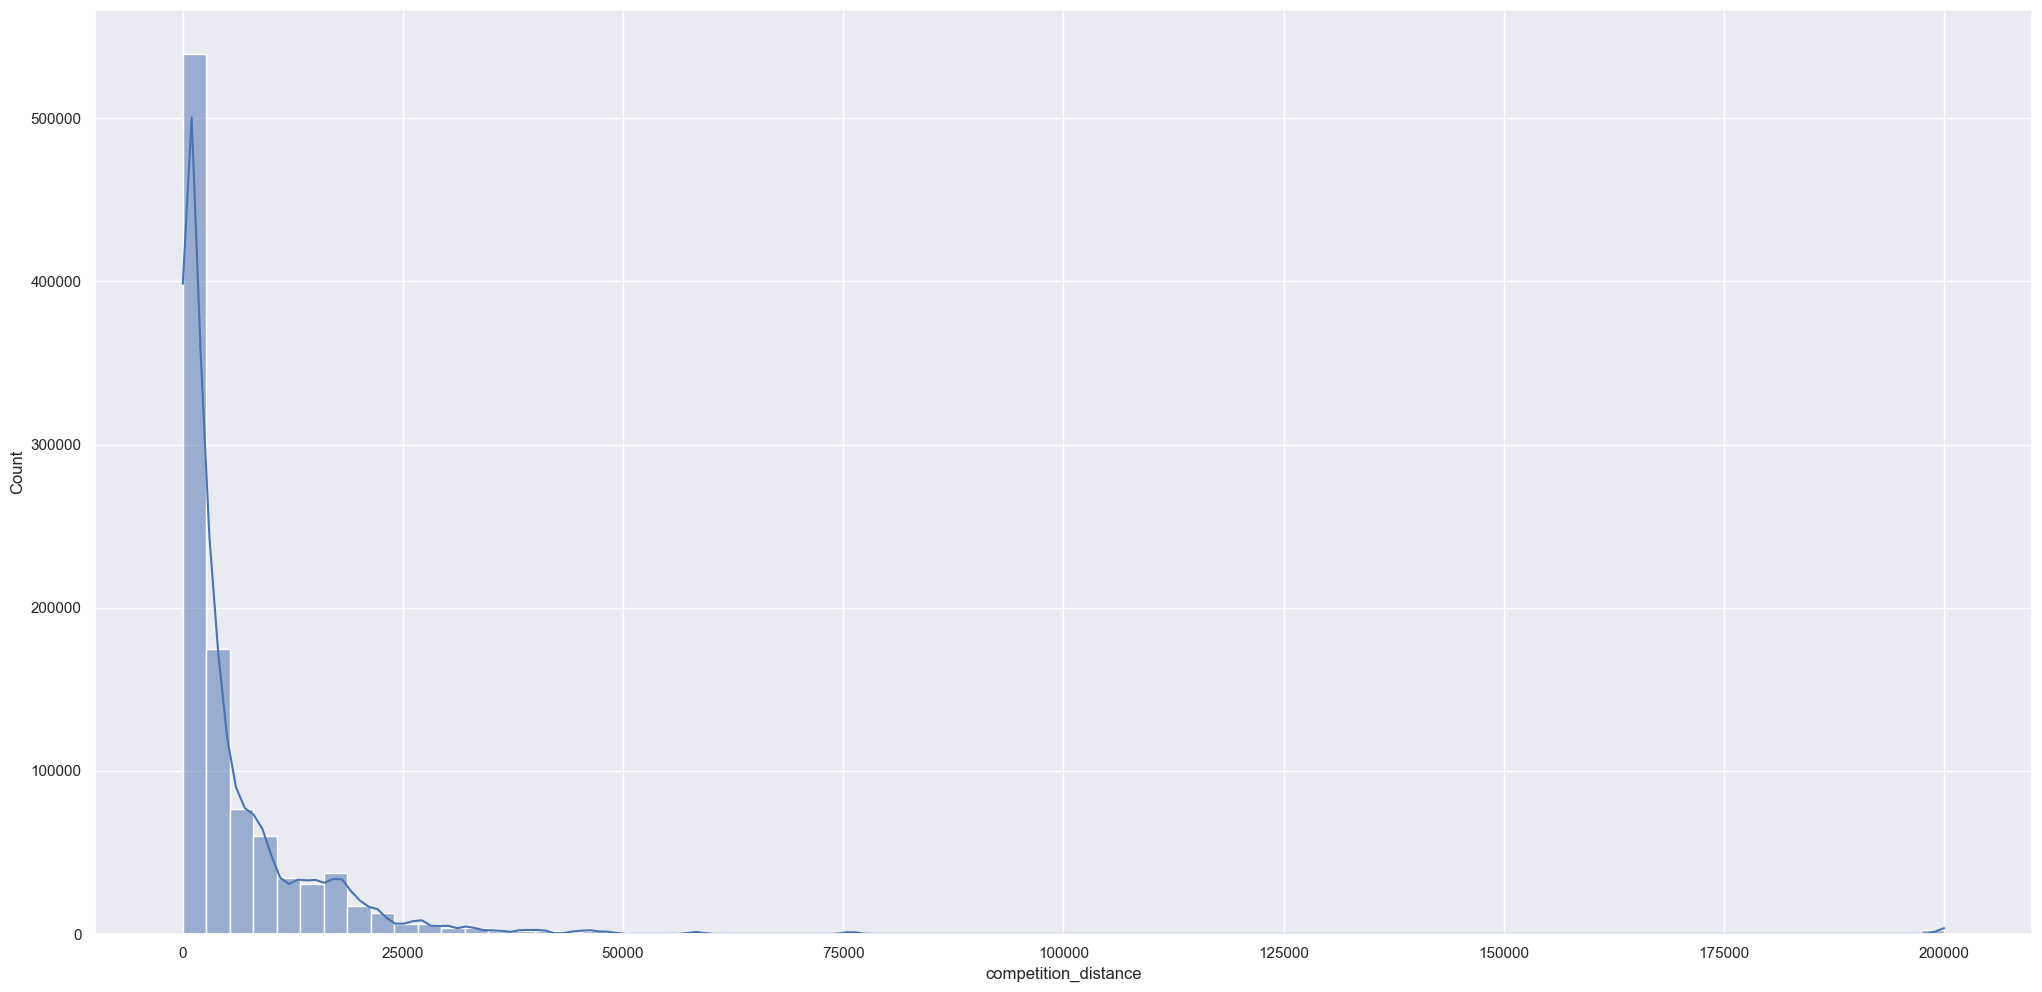

In [ ]:
sns.histplot( df1['competition_distance'], kde=True, bins=75 );

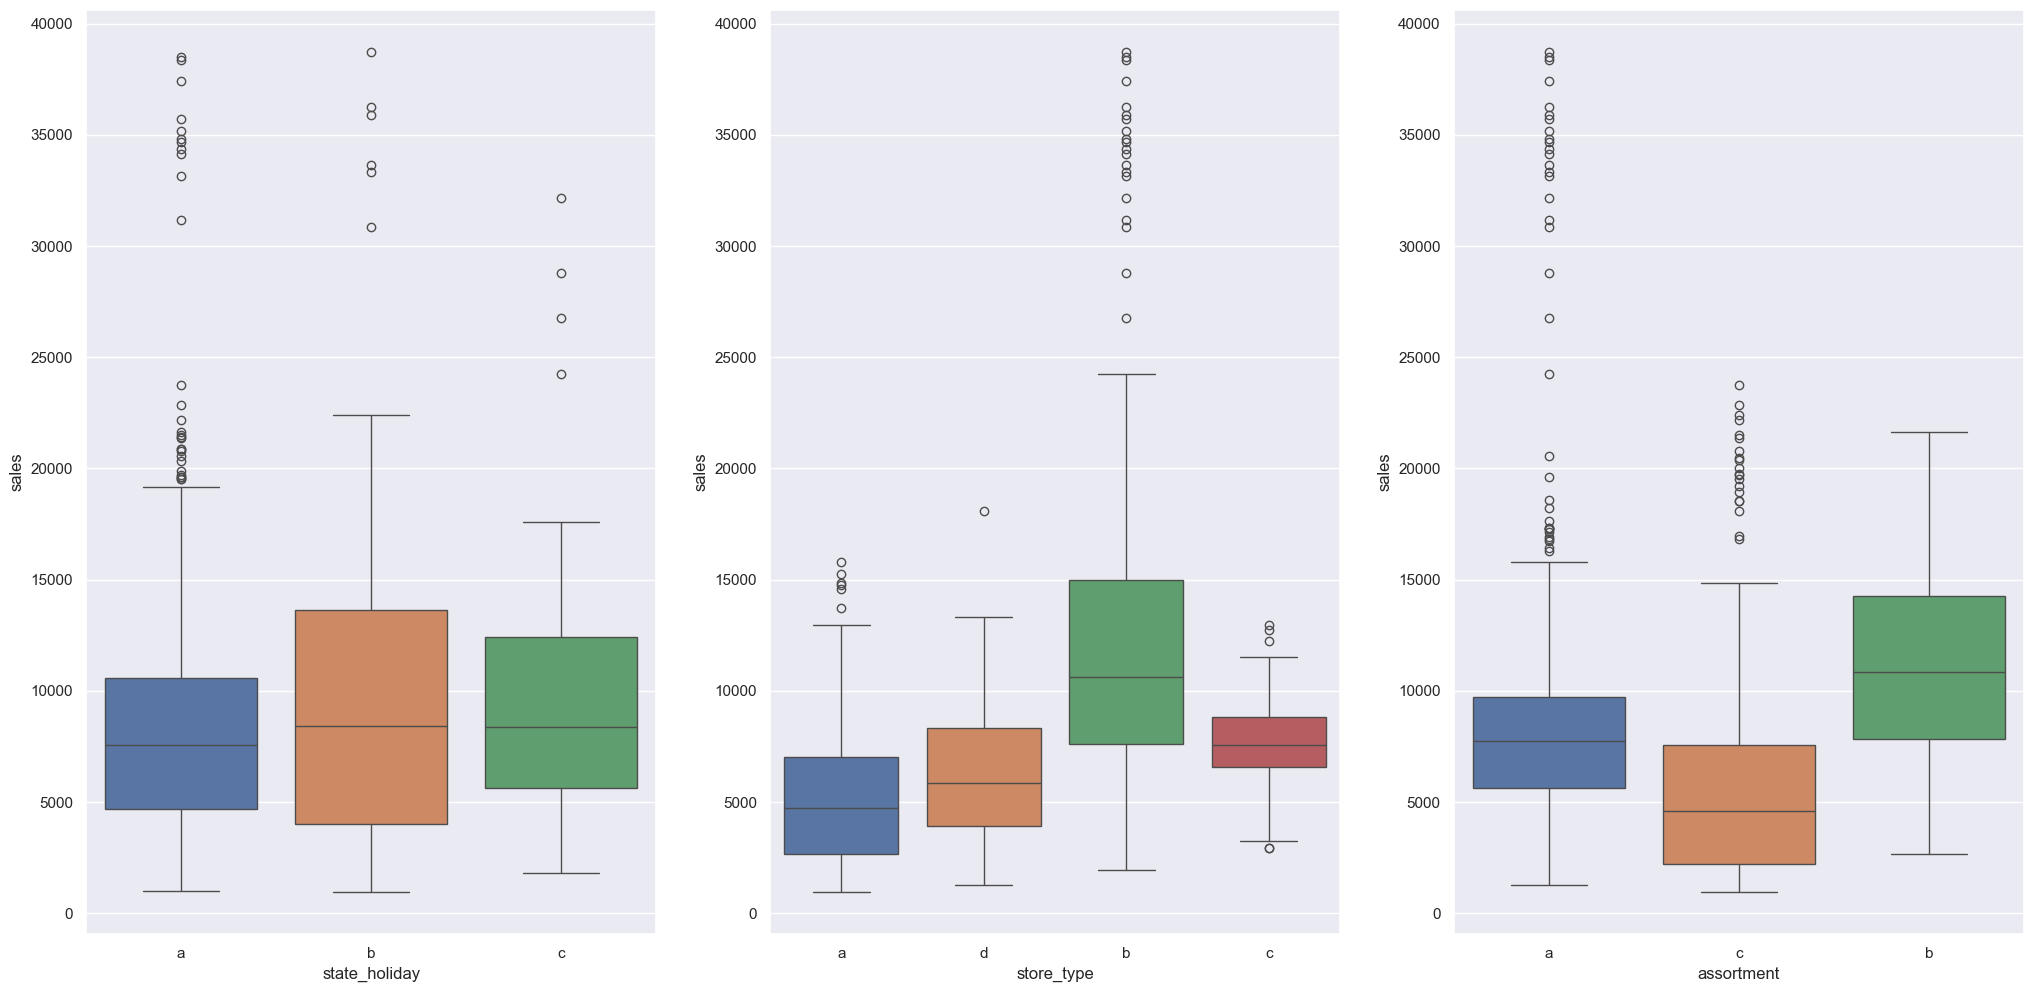

In [ ]:
aux1 = df1[ ( df1['state_holiday'] != '0') & ( df1['sales'] > 0 ) & ( df1['state_holiday'] != 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( data=aux1, x='state_holiday', y='sales', hue='state_holiday' )

plt.subplot( 1, 3, 2 )
sns.boxplot( data=aux1, x='store_type', y='sales', hue='store_type' )

plt.subplot( 1, 3, 3 )
sns.boxplot( data=aux1, x='assortment', y='sales', hue='assortment' );

*State Holiday*
- "b" possui maior variabilidade nas vendas, porém no "a" eu vejo mais outliers

*Store Type*
- Claramente no tipo "b" ocorrem mais vendas

*Assortment*
- o tipo 'C' parece ser o mais constante vendas, porem no "A" eu tenho alguns grandes outliers que valem a pena dar uma olhada

# 2.0. FEATURE ENGINEERING

In [13]:
df2 = df1.copy()

## 2.1. Mapa Mental das Hipóteses

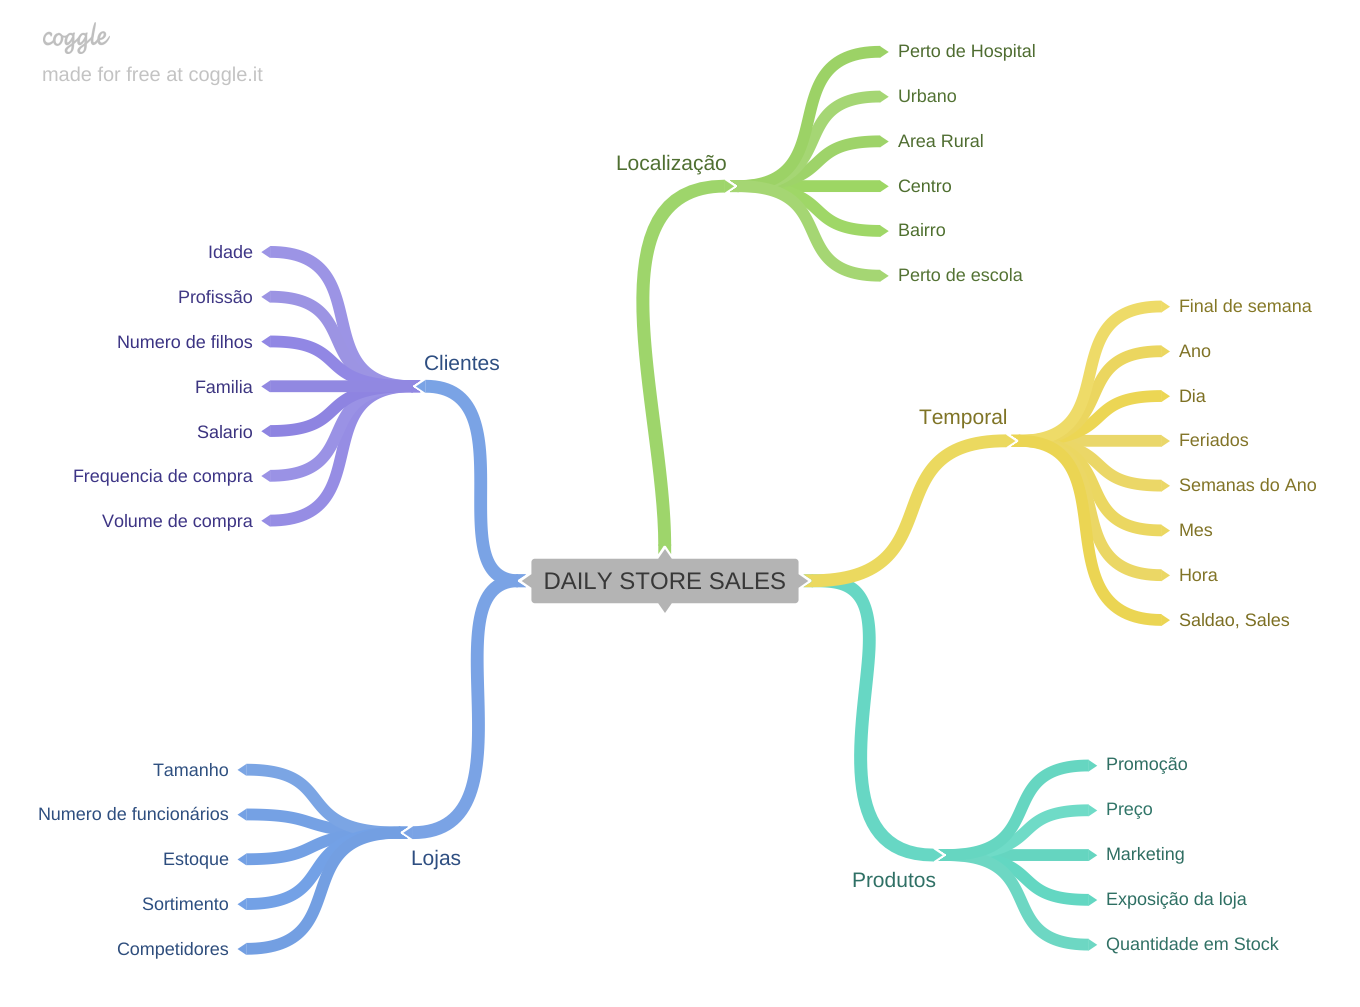

In [14]:
Image( '../img/MindMapHypotesis.png' )

## 2.2. Criação das Hipóteses    

### 2.2.1. Hipóteses de Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.


### 2.2.2. Hipóteses de Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.


### 2.2.3. Hipóteses de Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3. Lista Final das Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering


In [15]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week 

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], 
                                                                  month=x['competition_open_since_month'],day=1 ), axis=1 )

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# Assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' 
                                                                                          else 'christmas' if x == 'c' 
                                                                                          else 'regular_day' )

# 3.0. FILTRAGEM DE VARIAVEIS

In [16]:
df3 = df2.copy()

## 3.1. Filtragem das linhas

In [17]:
df3 = df3[ df3['sales'] > 0 ]

In [18]:
print(f'Dias em que não vendeu nada representa {round( (1 - ( df3.shape[0] / df1.shape[0]) ) * 100 )}% dos dados')

Dias em que não vendeu nada representa 17% dos dados


## 3.2. Seleção das colunas

In [19]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. ANÁLISE EXPLORATORIA DOS DADOS

In [20]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1 Response Variable

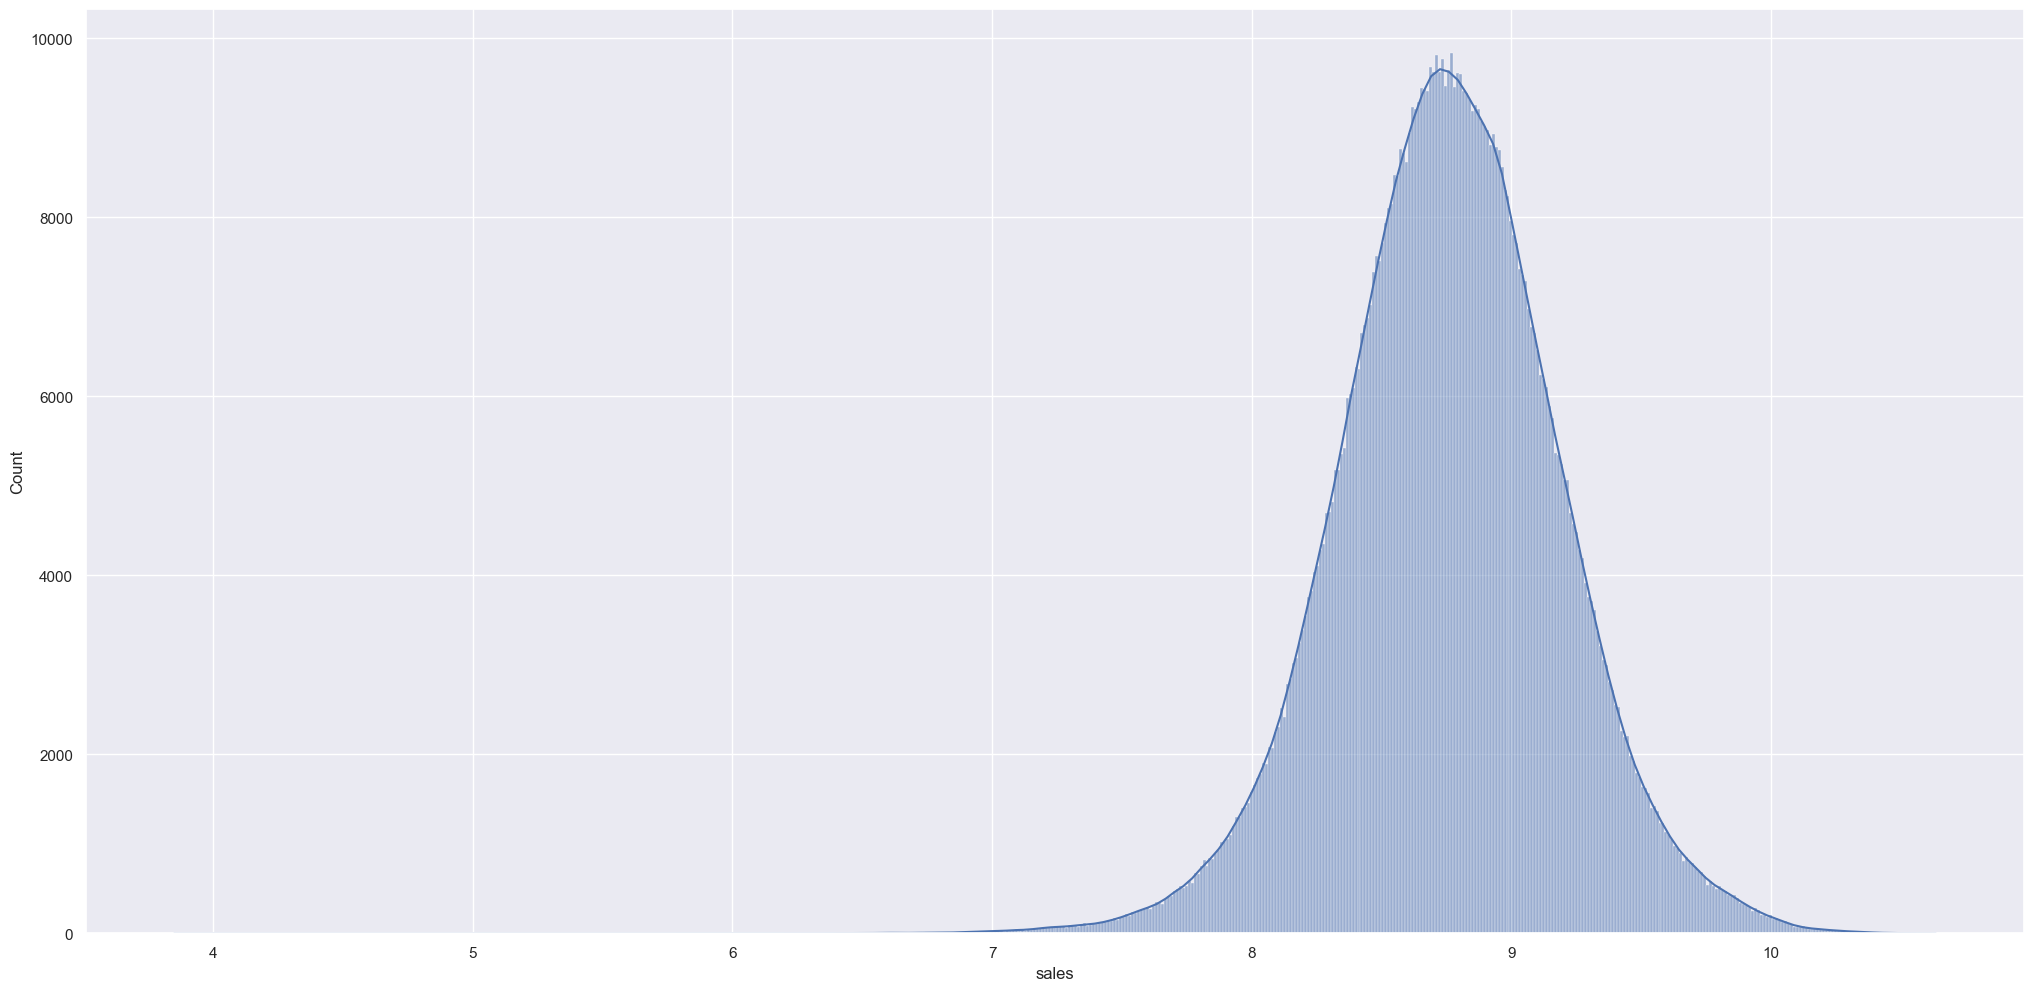

In [ ]:
## Fazendo o log da variavel alvo para deixar mais parecida com uma distribuição normal
sns.histplot(np.log1p( df4['sales'] ), kde=True ) ;

### 4.1.2. Numerical Variable

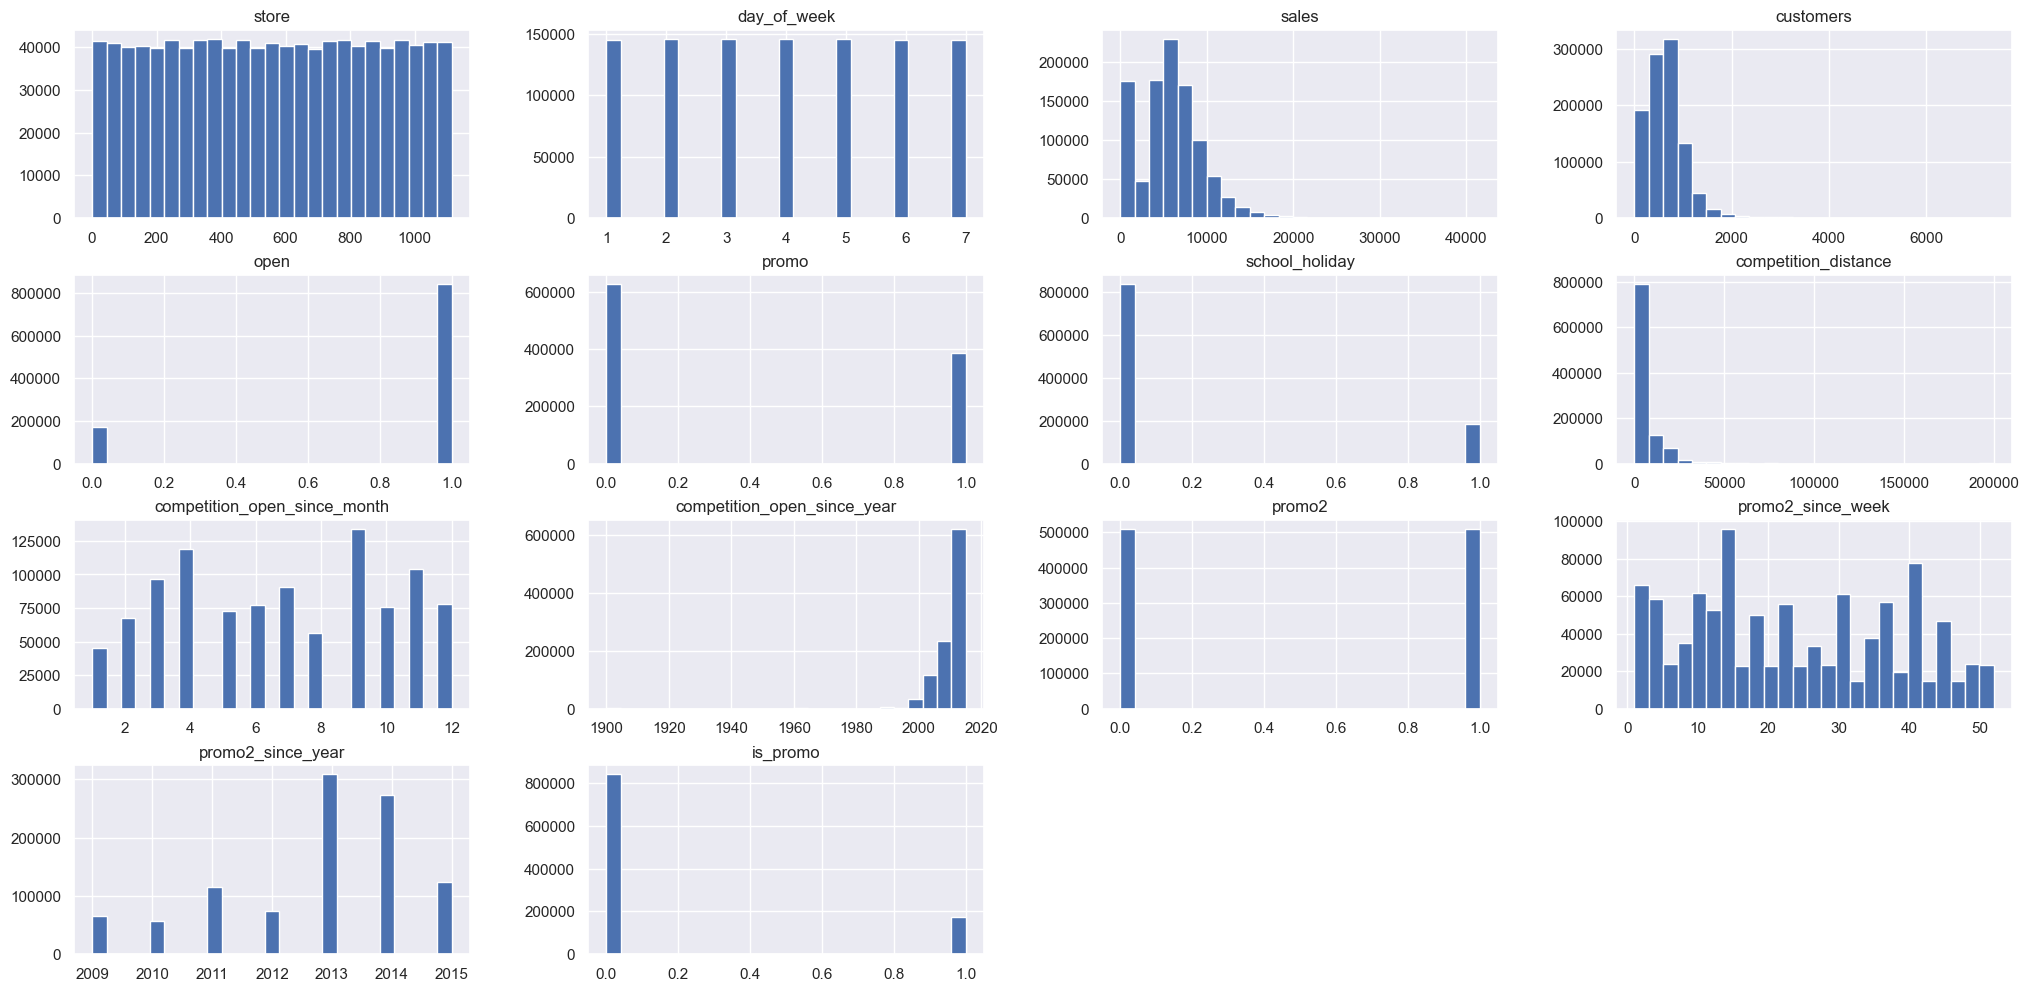

In [ ]:
# Vendo as distribuições gerais
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

In [ ]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<Axes: xlabel='sales', ylabel='Density'>

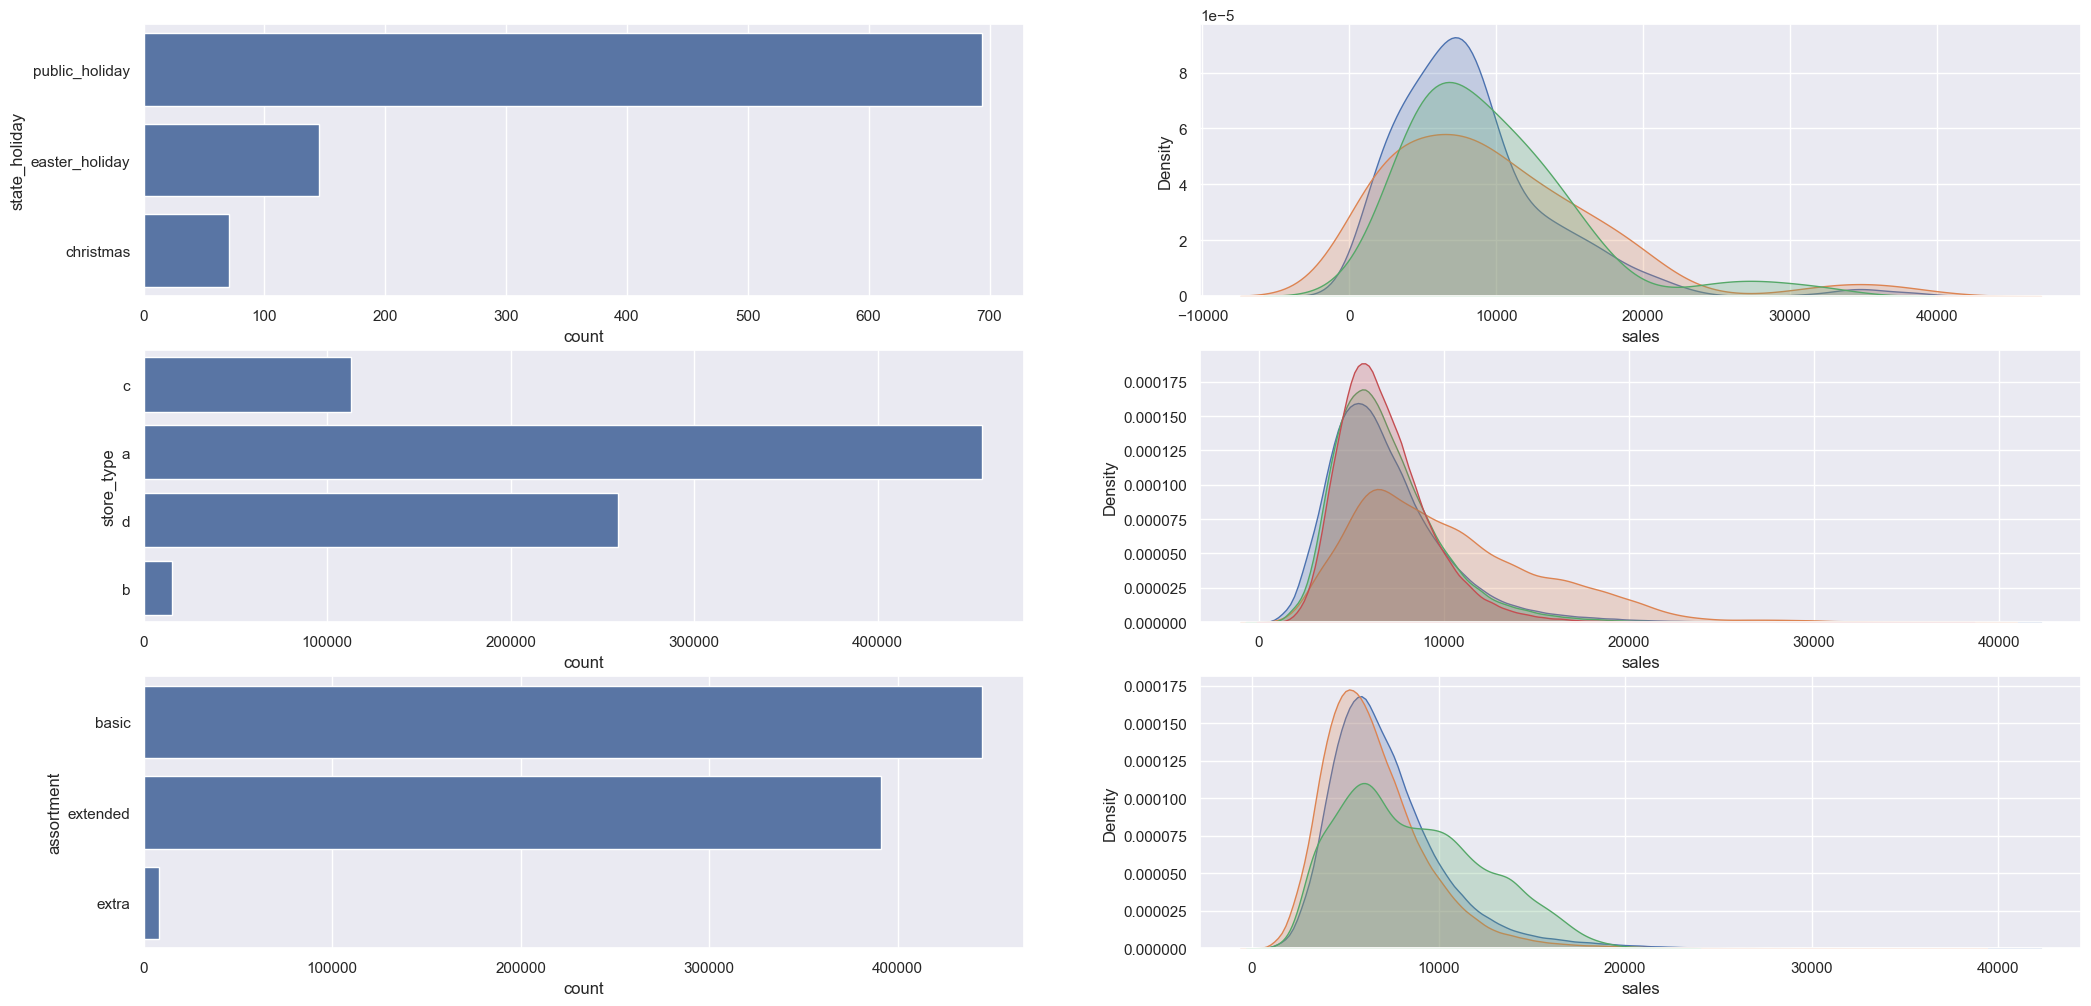

In [ ]:
# STATE HOLIDAY
plt.subplot( 3, 2, 1  )
a = df4[ df4['state_holiday'] != 'regular_day' ]
sns.countplot(a['state_holiday']);

plt.subplot( 3, 2, 2  )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# STORE TYPE
plt.subplot( 3, 2, 3  )
sns.countplot(df4['store_type']);

plt.subplot( 3, 2, 4  )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# ASSORTMENT
plt.subplot( 3, 2, 5  )
sns.countplot(df4['assortment']);

plt.subplot( 3, 2, 6  )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )


## 4.2. Análise Bivariada

### 1. Lojas com maior sortimentos deveriam vender mais na média
**VERDADEIRO** Lojas com MAIOR SORTIMENTO vendem MAIS na média.


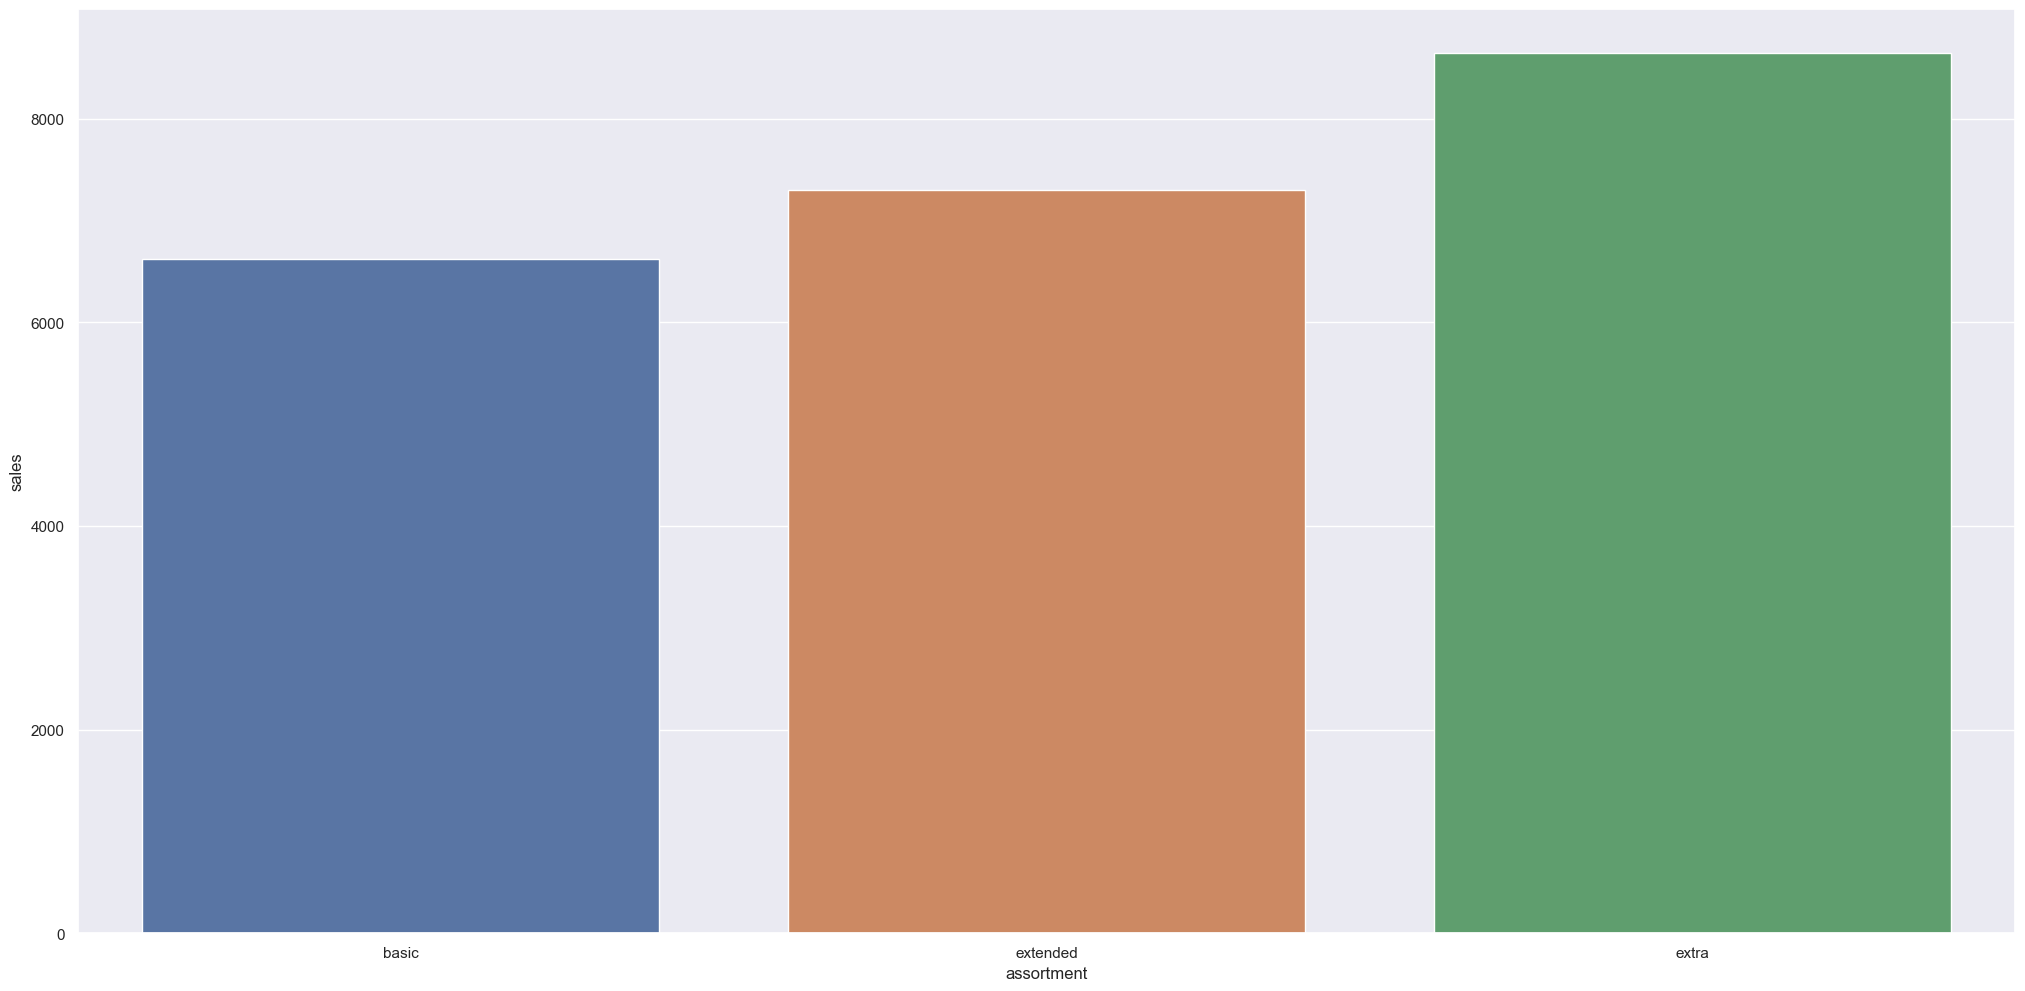

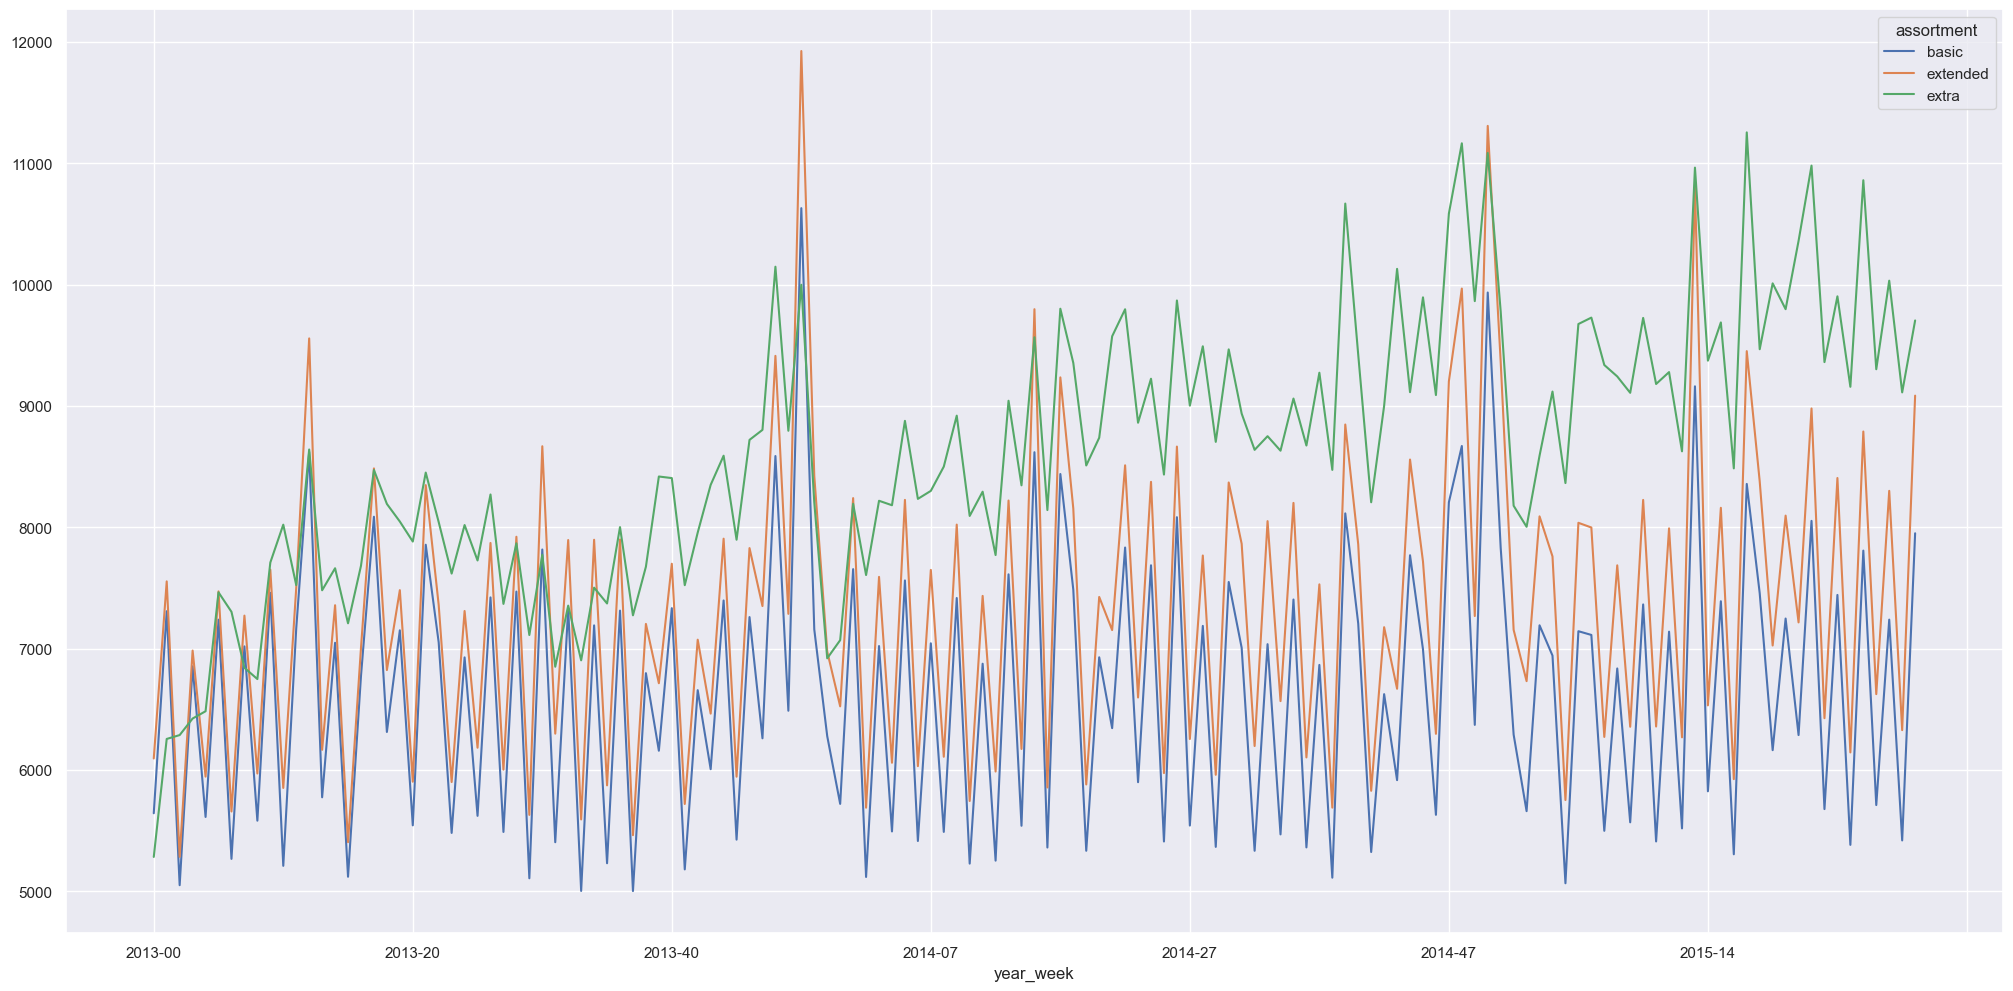

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, hue='assortment');

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).mean().reset_index()
aux2.pivot( index='year_week' , columns='assortment' , values='sales' ).plot();

### 2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com competidores MAIS PROXIMOS vendem MAIS

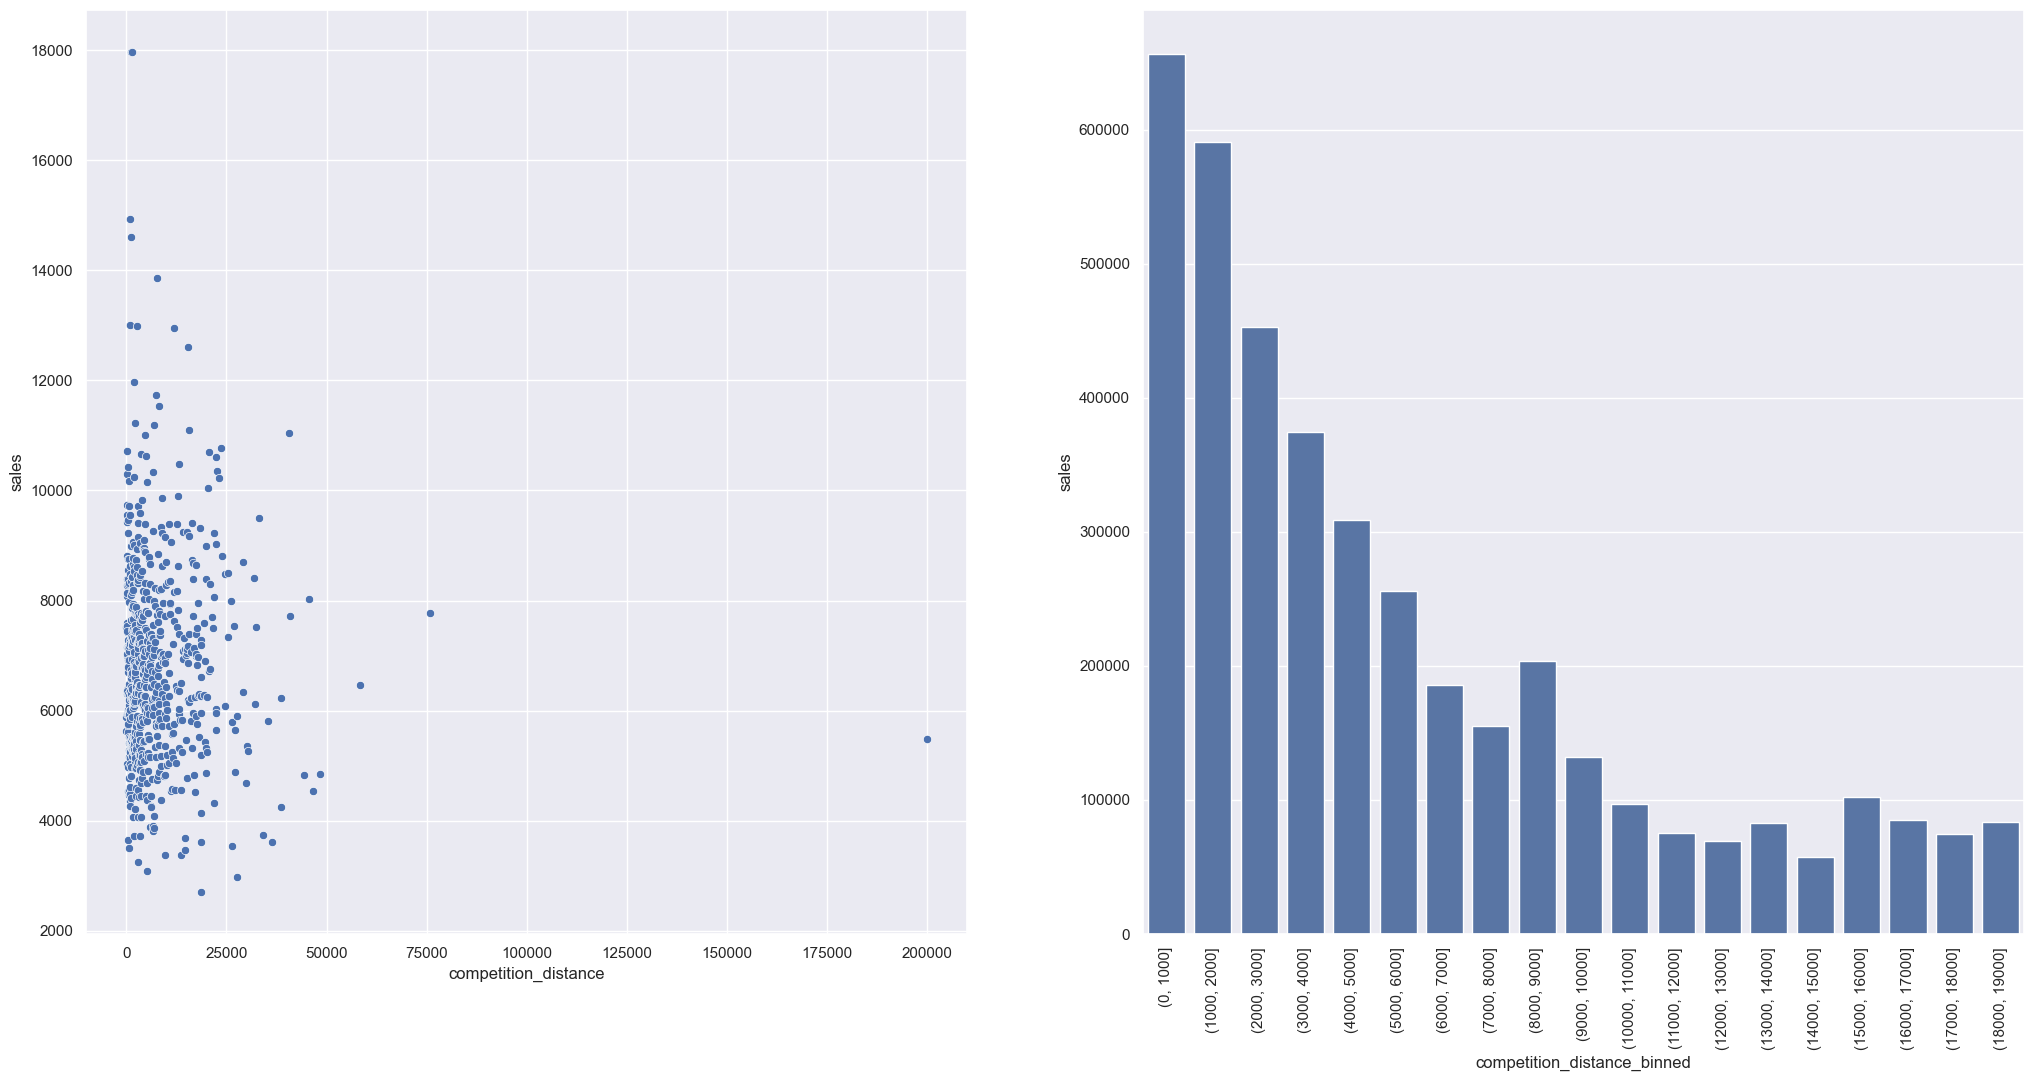

In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

plt.subplot(1, 2, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 2, 2)
bins = list( np.arange( 0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

### 3. Lojas com competidores à mais tempo deveriam vender mais na média
**FALSA** Lojas com competidores a MAIS TEMPO vendem MENOS.

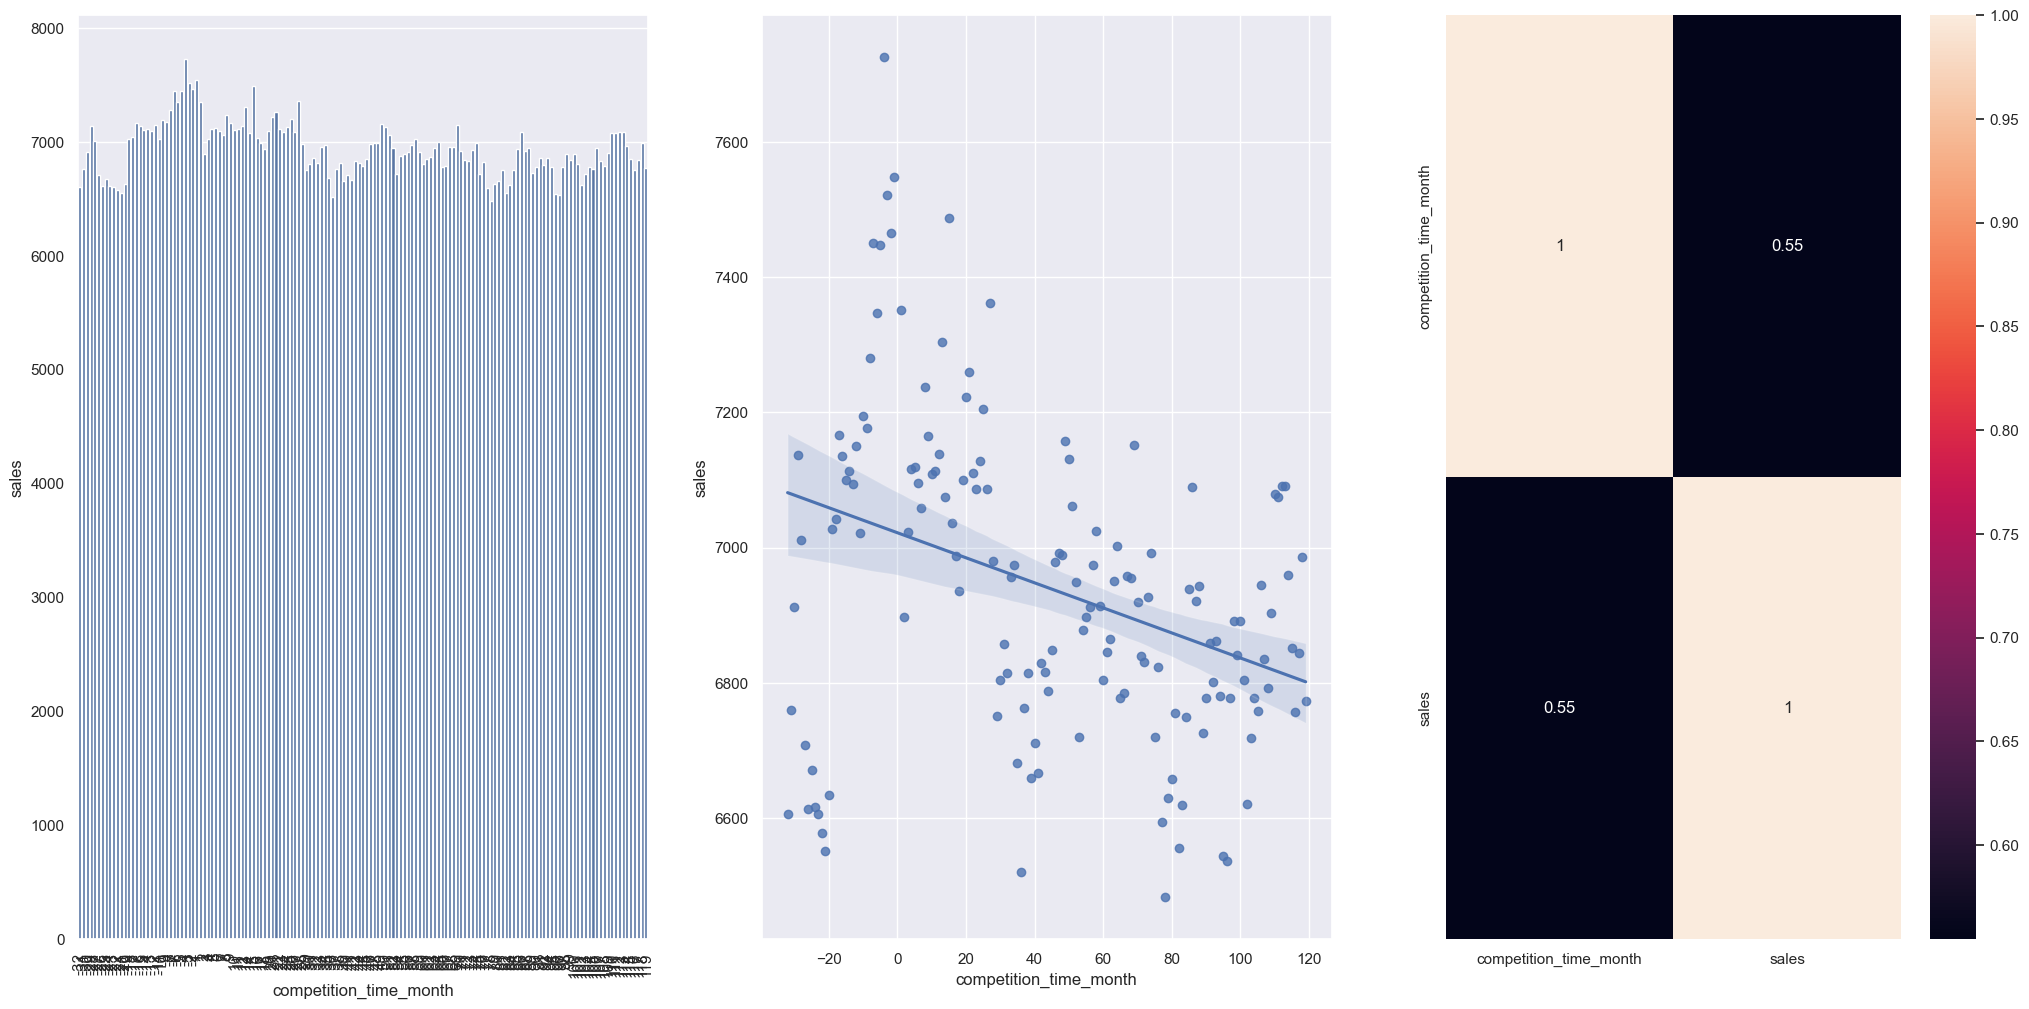

In [ ]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 ) ]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo
de promocao

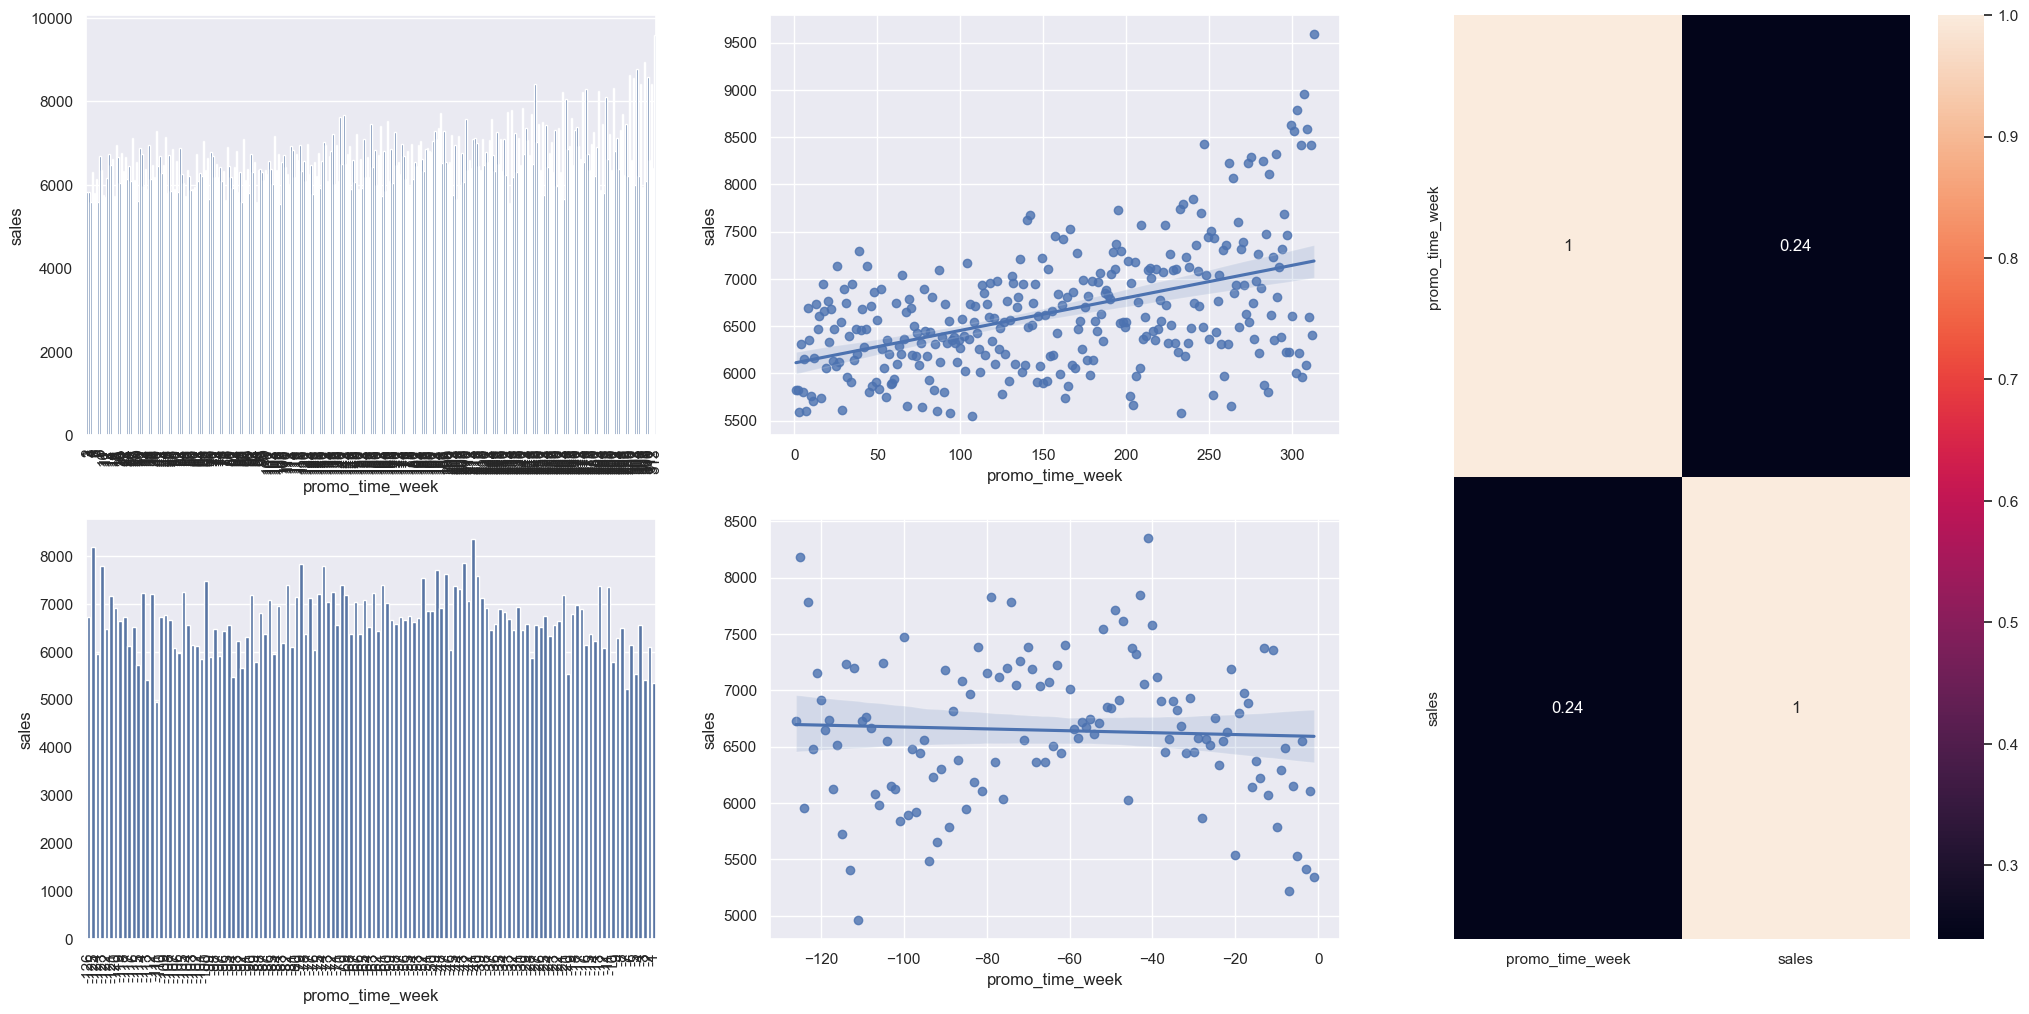

In [ ]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').mean().reset_index()

grid = plt.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 5. Lojas com mais dias de promoção deveriam vender mais.


### 6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).mean().reset_index().sort_values('sales', ascending=False)

,promo,promo2,sales
2,1,0,8618.452062
3,1,1,7836.672987
0,0,0,6328.187633
1,0,1,5529.566684


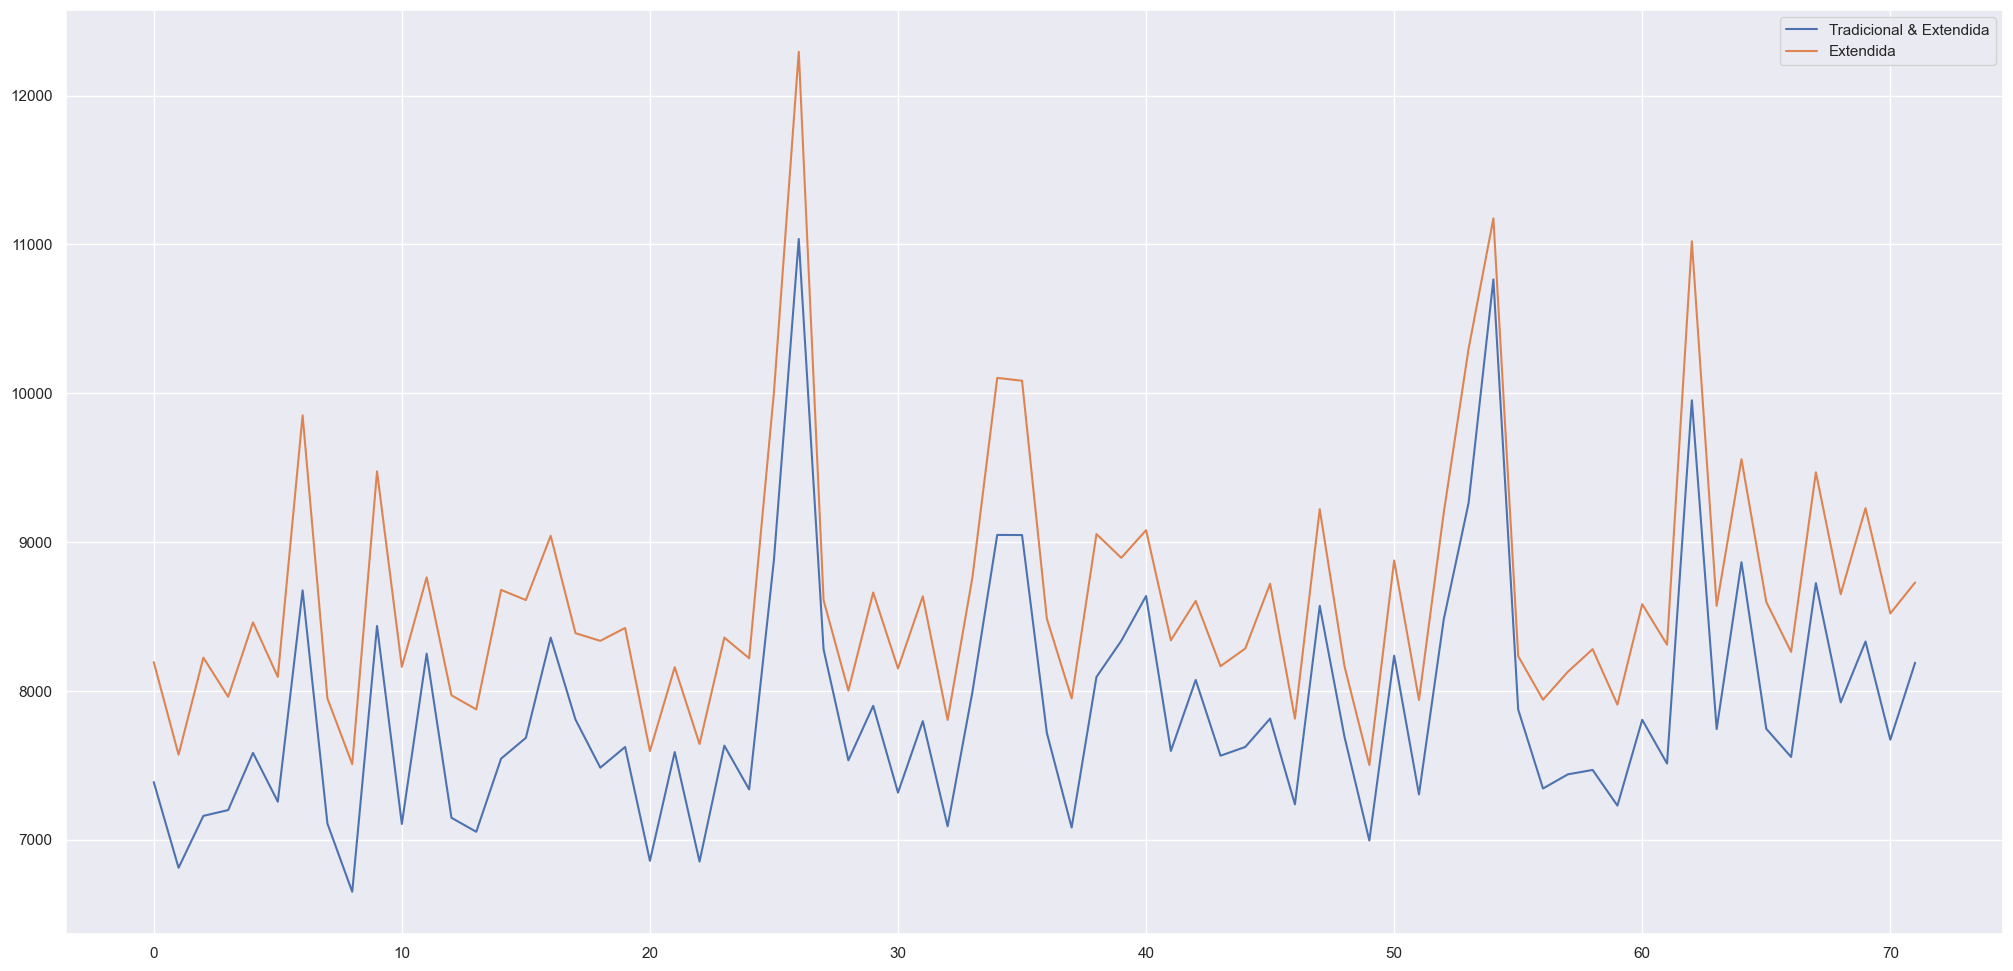

In [ ]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).mean().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).mean().reset_index()
aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### 7. Lojas abertas durante o feriado de Natal deveriam vender mais na média
**VERDADEIRO** Na media lojas abertas durante o natal vendem mais.

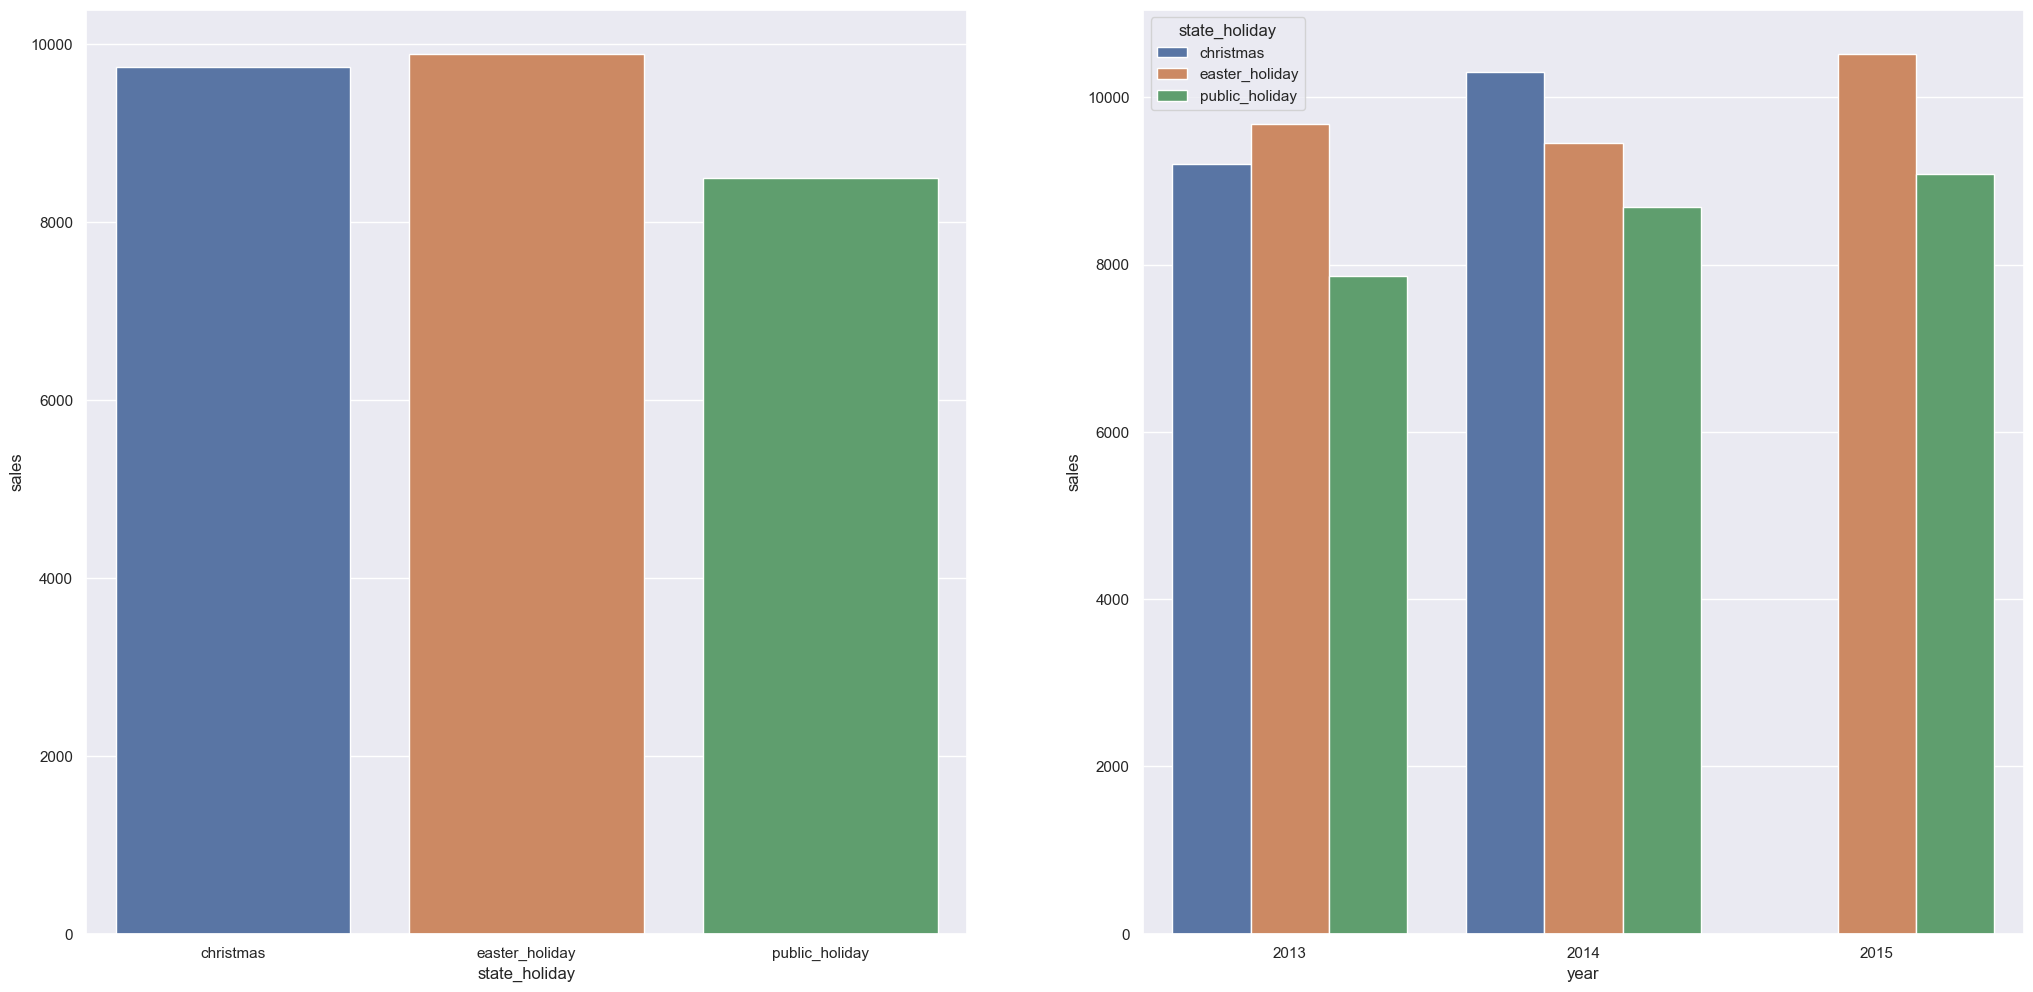

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1, hue='state_holiday' );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).mean().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### 8. Na média lojas deveriam vender mais ao longo dos anos.
**VERDADEIRO** Lojas vendem MAIS ao longo dos anos

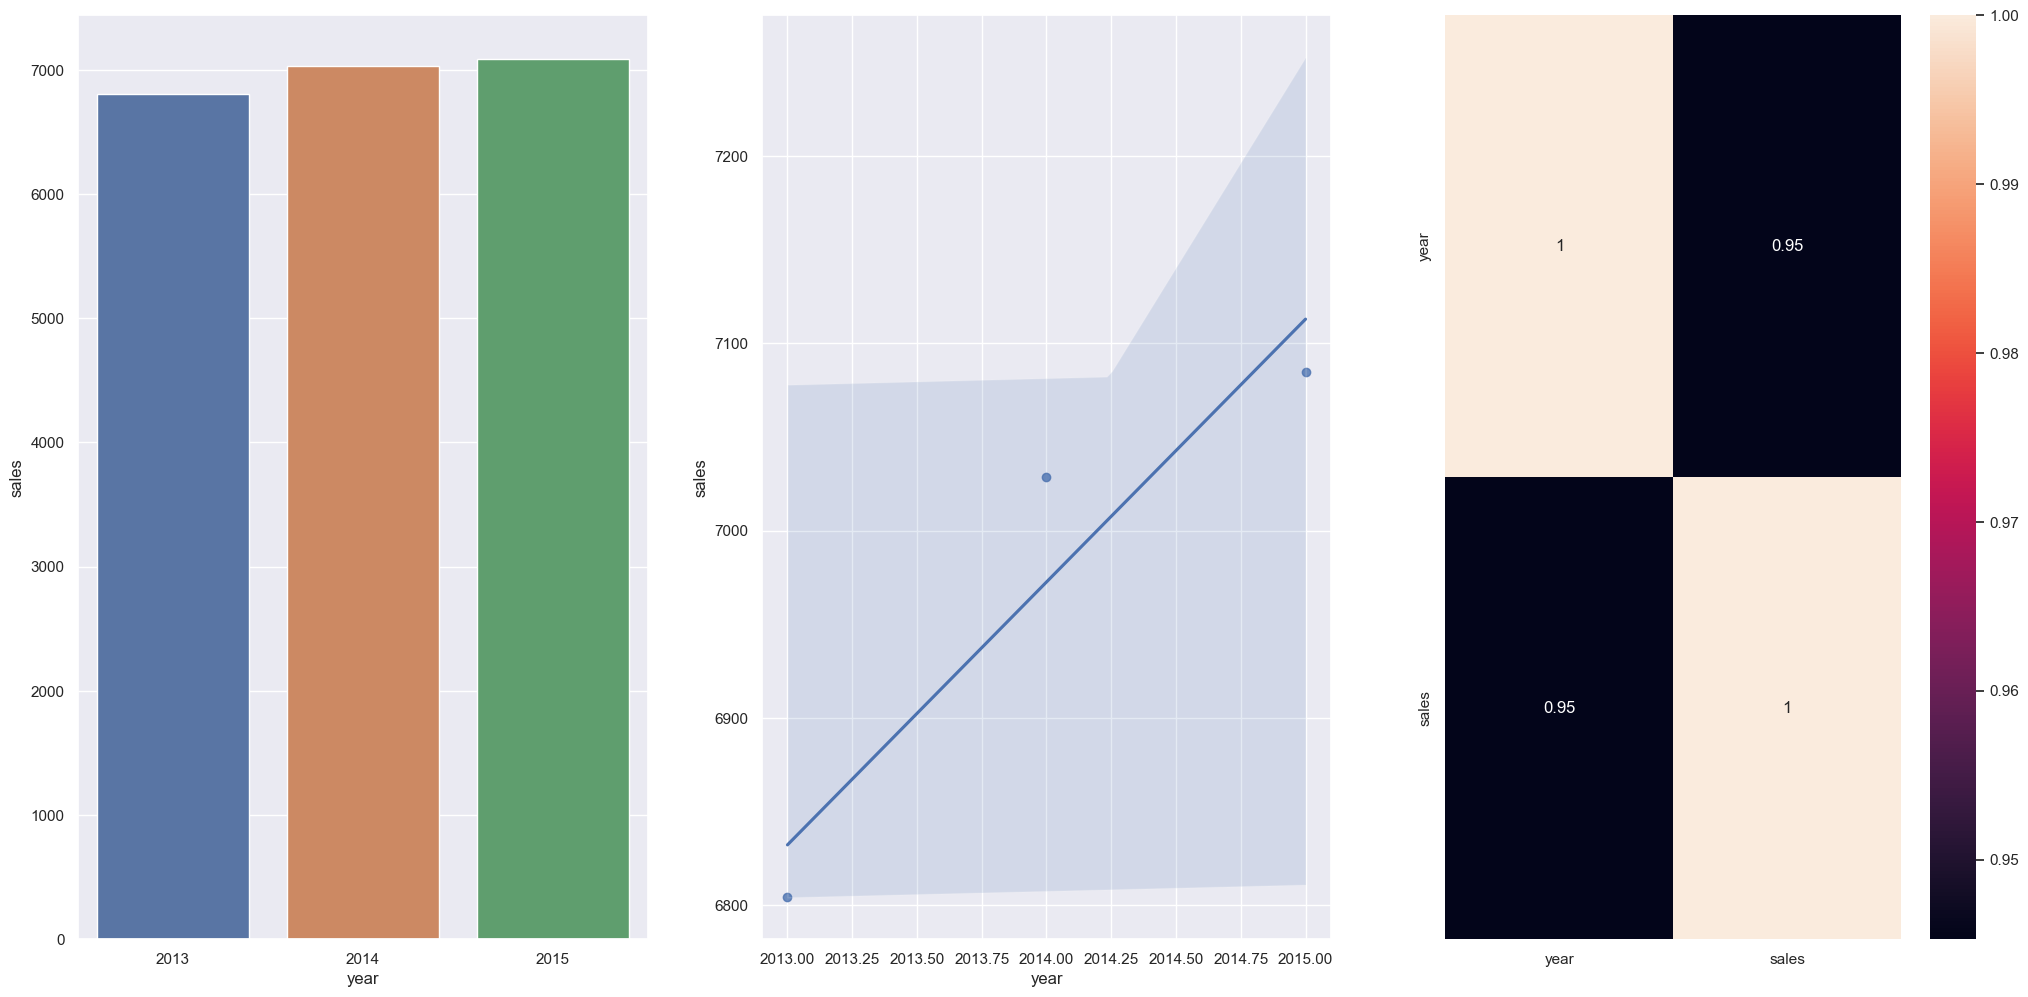

In [ ]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 9. Lojas deveriam vender mais no segundo semestre do ano.
**VERDADEIRO** Lojas vendem MAIS no segundo semestre do ano

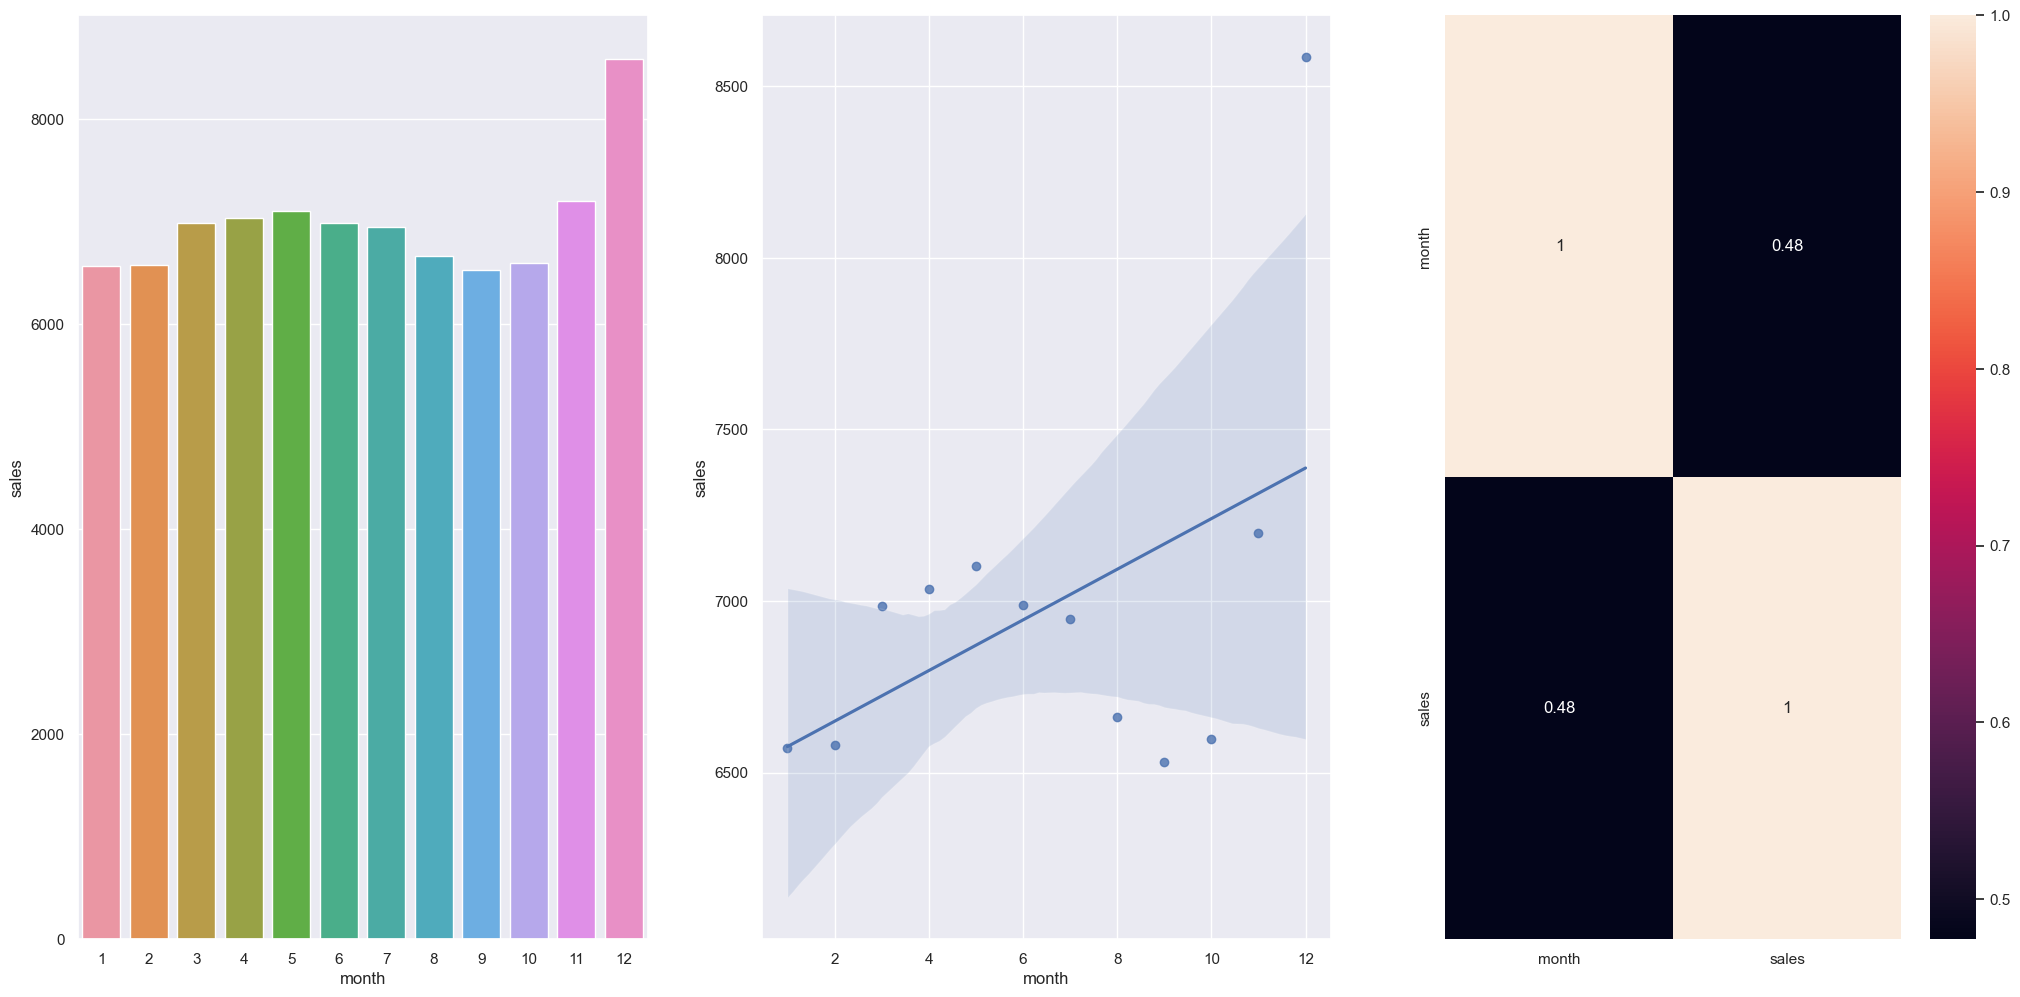

In [ ]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 10. Na média lojas deveriam vender mais depois do dia 10 de cada mês.
**FALSO** Lojas vendem mais depois do dia 10 de cada mes.

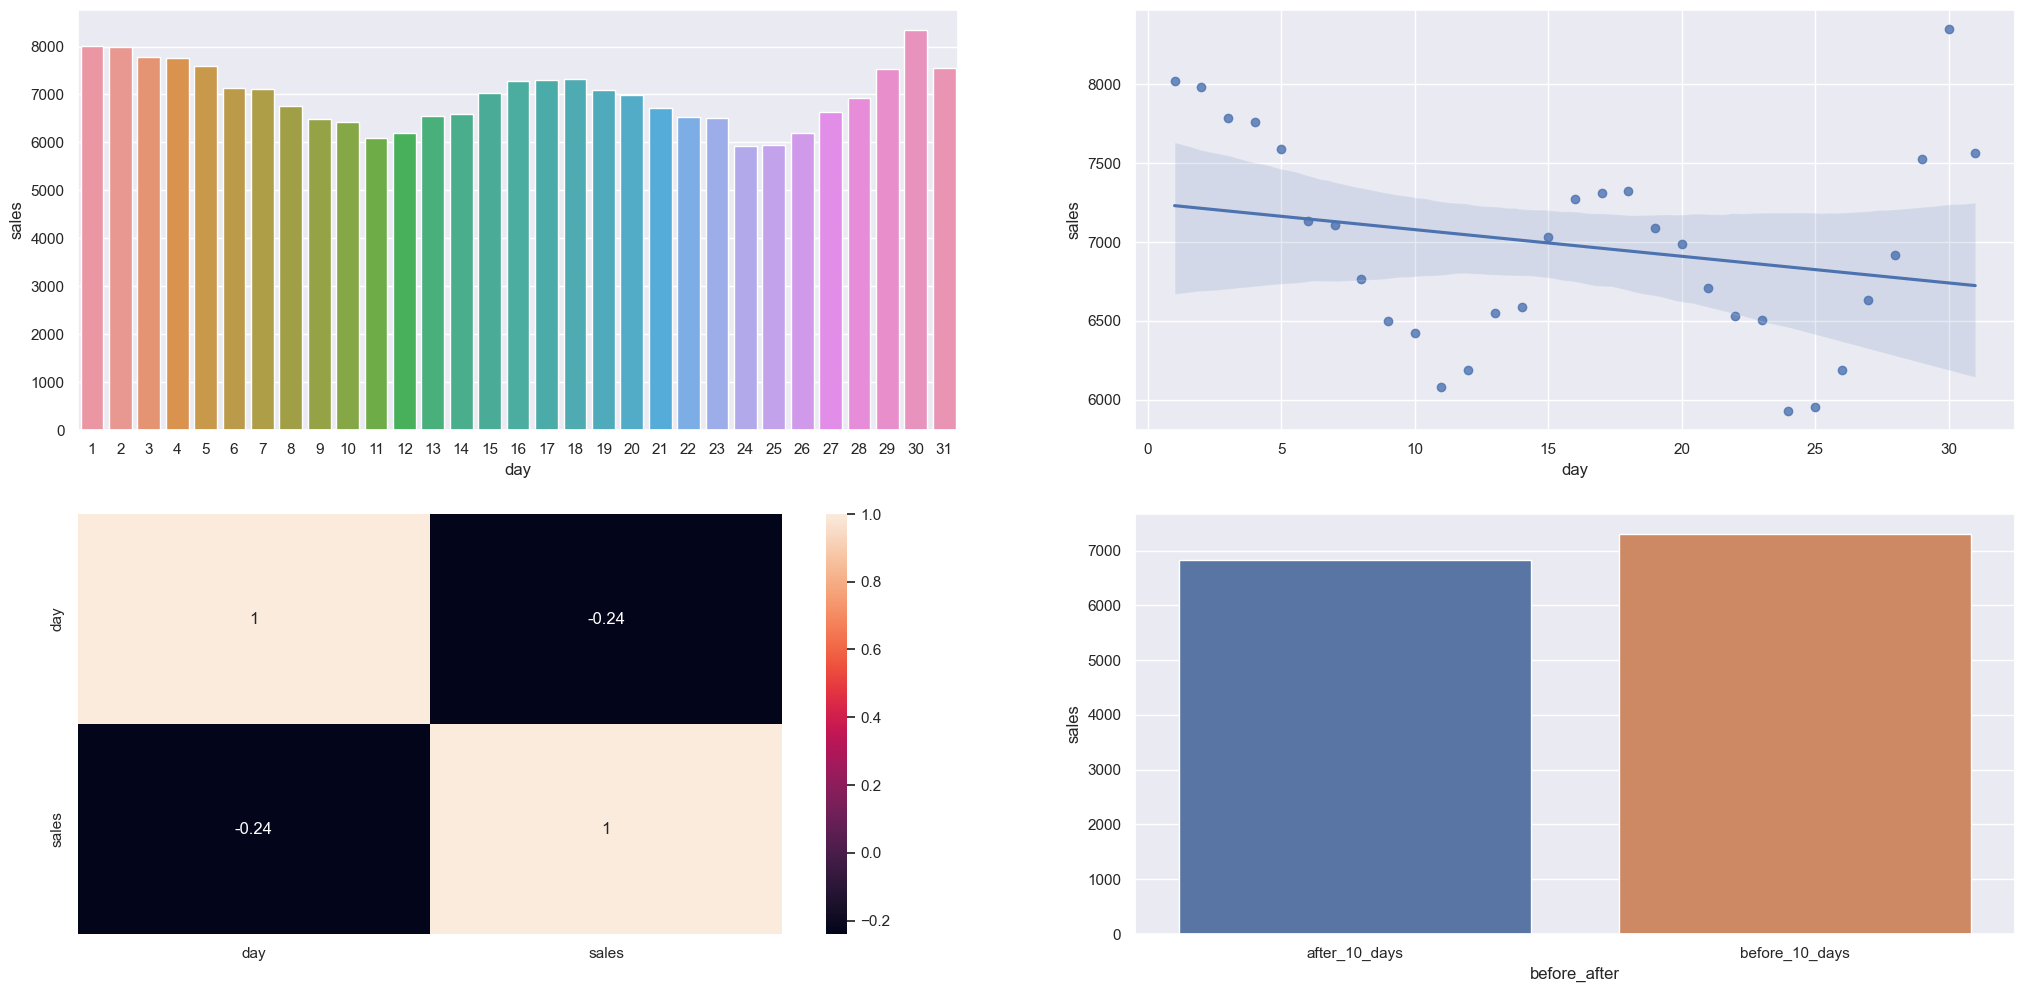

In [ ]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).mean().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).mean().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### 11. Lojas deveriam vender menos aos finais de semana.
**FALSO**  Lojas vendem MAIS nos final de semana

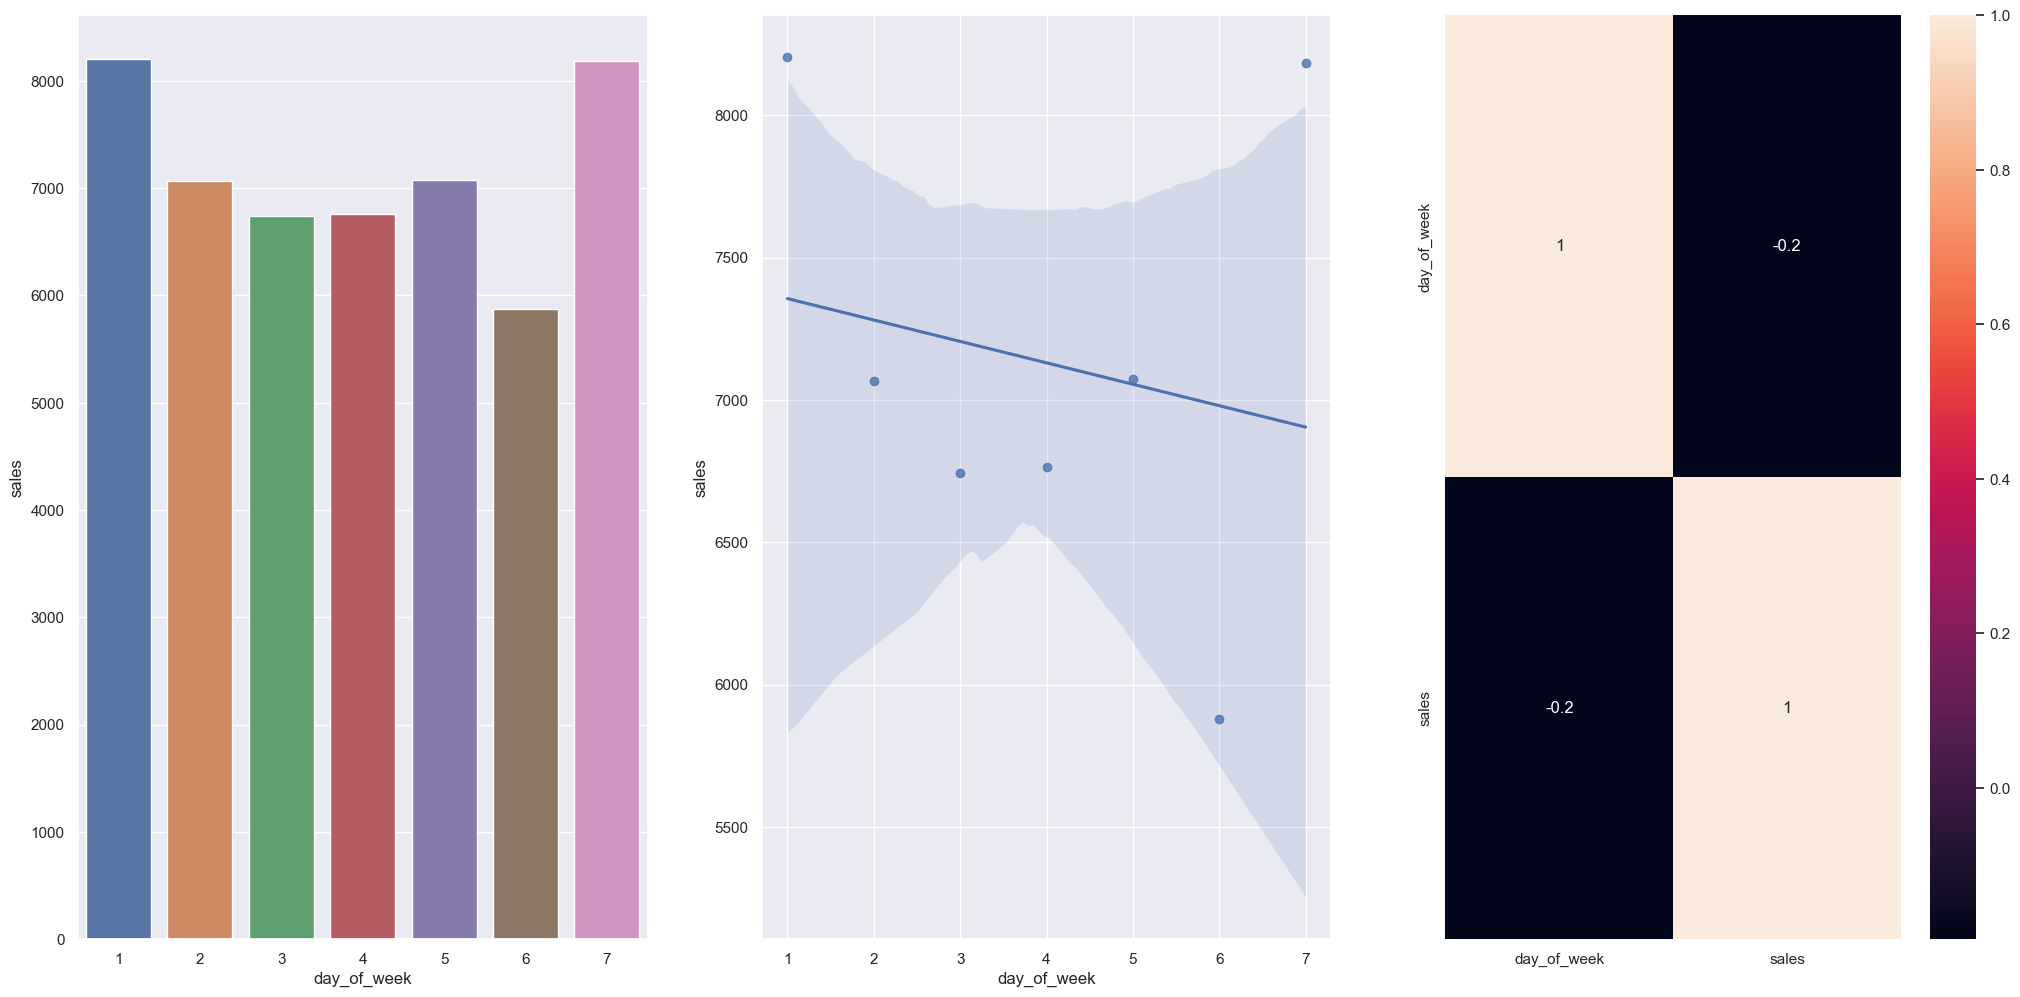

In [ ]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 12. Lojas deveriam vender menos na média durante os feriados escolares.
***FALSO*** Lojas vendem mais durante os feriados escolares, exceto os meses de Set, Out e Dez

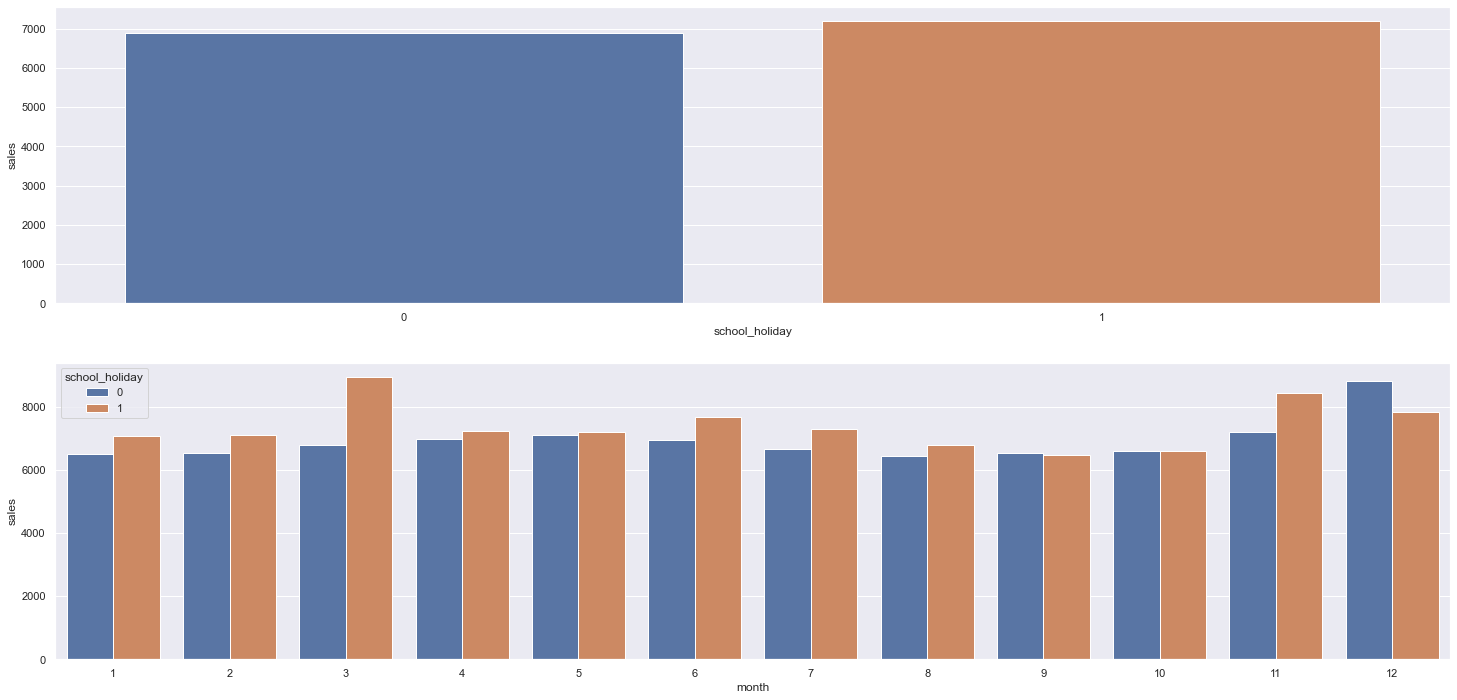

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).mean().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).mean().reset_index()

plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.2. Resumo das Hipóteses

In [ ]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Verdadeira', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Falsa', 'Baixa']]

print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Verdadeira   Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Falsa        Baixa


## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

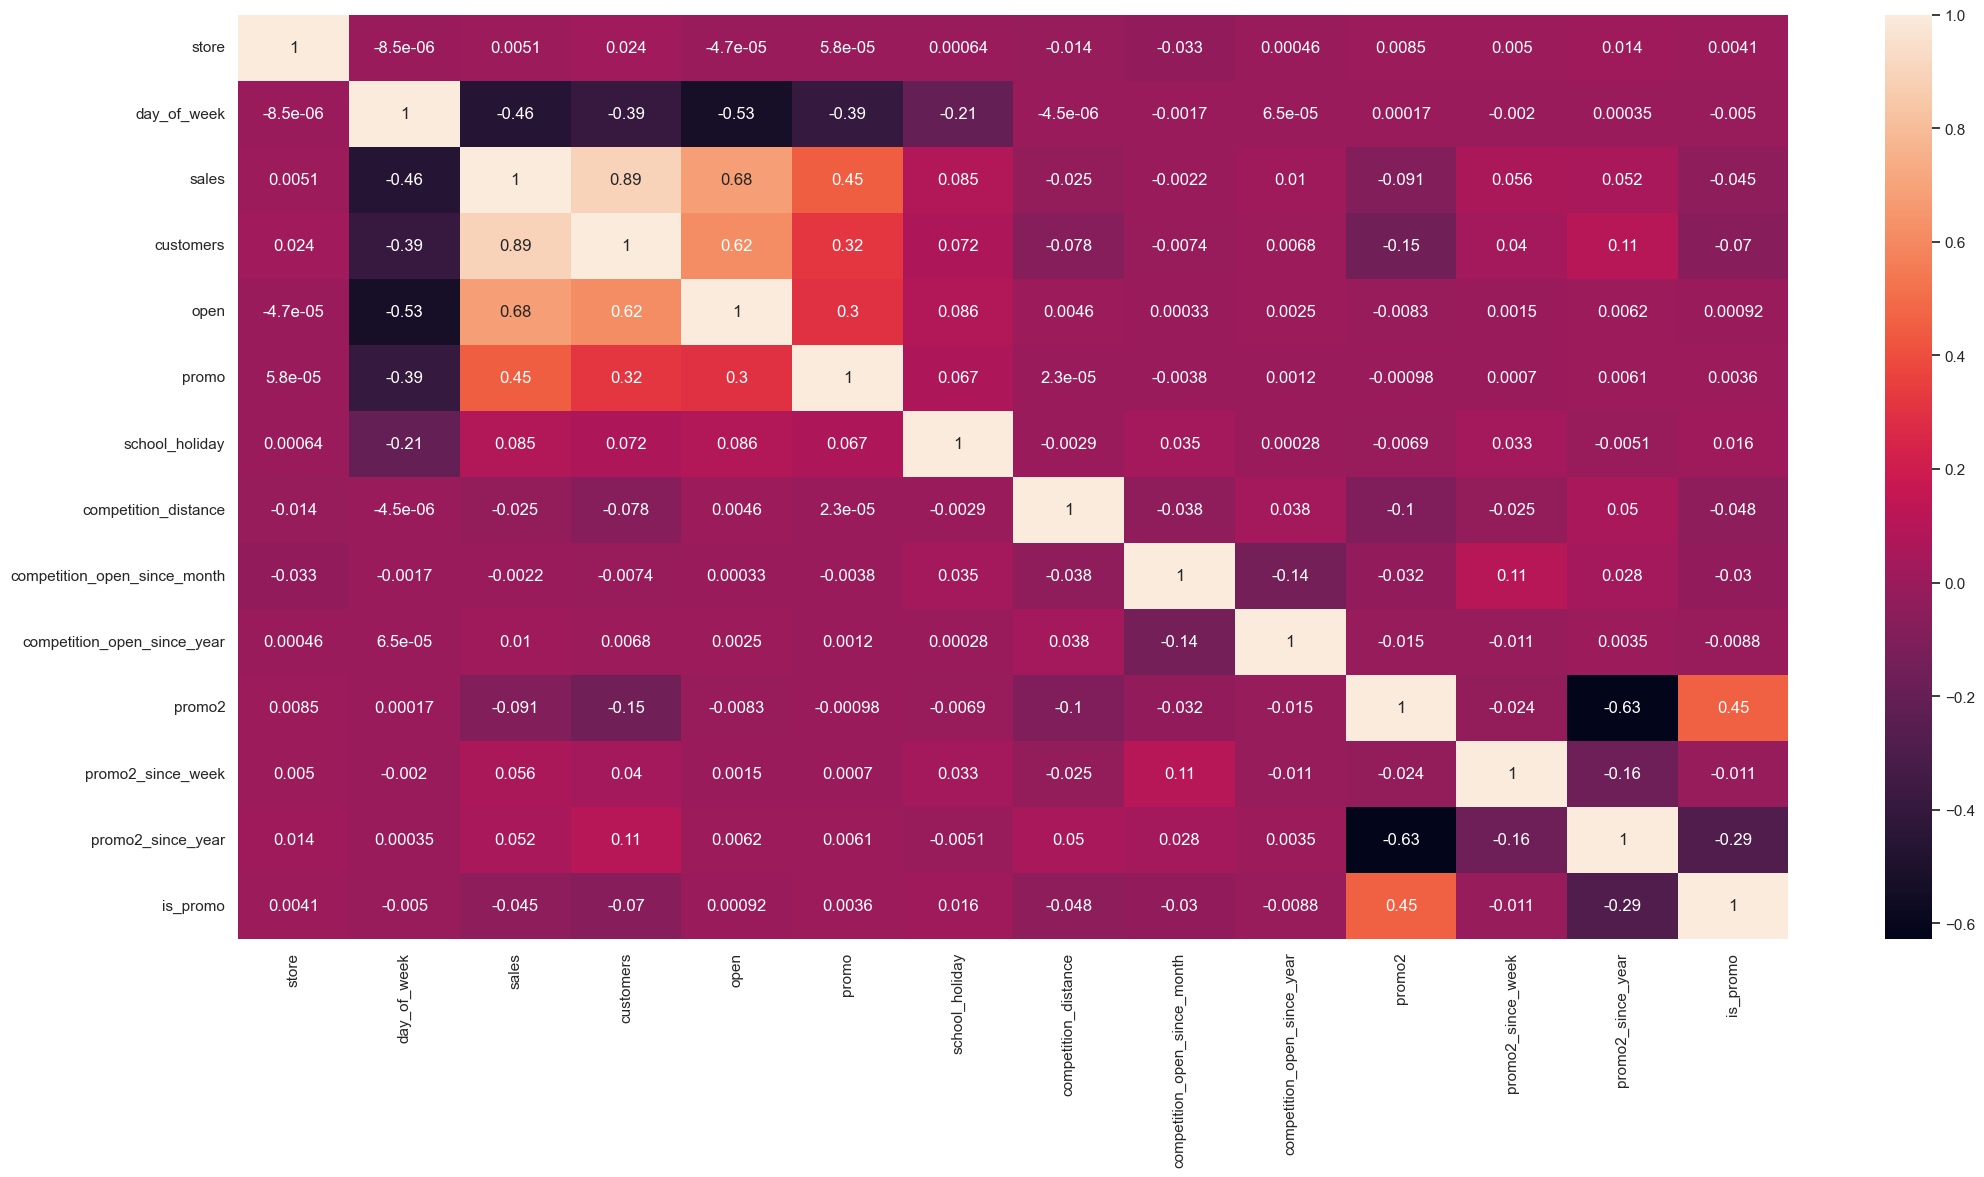

In [ ]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

In [ ]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                    'store_type': [a4, a5, a6],
                    'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

AttributeError: 'DataFrame' object has no attribute 'chi2_contingency'

# 5.0 DATA PREPARATION

In [21]:
df5 = df4.copy()

## 5.1. Split dataframe into training and test dataset 

In [22]:
# Dropping old features
cols_drop = [ 'promo_since', 'competition_since', 'year_week' ]
df5 = df5.drop( cols_drop, axis=1 )

In [23]:
# Split temporal (treino/teste)
train_cutoff = '2015-06-19'
X_train = df5[df5['date'] < train_cutoff].copy()
X_test  = df5[df5['date'] >= train_cutoff].copy()


# Separar features e alvo
y_train = X_train['sales'].copy()
y_test  = X_test['sales'].copy()


# Resetar index
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 5.1. Normalização

## 5.2. Rescaling

In [24]:
scaling_config = {
    'competition_distance': RobustScaler(),
    'competition_time_month': RobustScaler(),
    'promo_time_week': MinMaxScaler(),
    'year': MinMaxScaler()
}

# Caminho para salvar os scalers
scaler_path = '../parameter/'

# Aplicando todos os scalers
for col, scaler in scaling_config.items():
    scale_and_save(X_train, X_test, col, scaler, scaler_path)

## 5.3. Transformation

### 5.3.1. Encoding

In [25]:
# -----------------------------
# store - Target Encoding
# -----------------------------
encoded_col, mapping_dict, global_mean = target_encode_cv(X_train, col="store", target="sales", n_splits=5, alpha=1)

X_train["store_te"] = encoded_col
X_test["store_te"] = X_test["store"].map(mapping_dict).fillna(global_mean)

pickle.dump(mapping_dict, open('../parameter/store_te_mapping.pkl', 'wb'))
pickle.dump(global_mean, open('../parameter/store_te_global_mean.pkl', 'wb'))



# state_holiday - One Hot Encoding
X_train = pd.get_dummies(X_train, columns=['state_holiday'], prefix='state_holiday')
X_test  = pd.get_dummies(X_test, columns=['state_holiday'], prefix='state_holiday')

# Garantir mesmas colunas no teste
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# -----------------------------
# store_type - Label Encoding
# -----------------------------
le_store = LabelEncoder()
X_train['store_type'] = le_store.fit_transform(X_train['store_type'])
X_test['store_type']  = le_store.transform(X_test['store_type'])

pickle.dump(le_store, open('../parameter/store_type_encoder.pkl', 'wb'))

# -----------------------------
# assortment - Ordinal Encoding
# -----------------------------
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}

X_train['assortment'] = X_train['assortment'].map(assortment_dict)
X_test['assortment']  = X_test['assortment'].map(assortment_dict)

# Preencher possíveis NaNs (caso surjam novos valores)
X_train['assortment'].fillna(0, inplace=True)
X_test['assortment'].fillna(0, inplace=True)


### 5.3.2. Response Variable Transformation

In [26]:
y_train = np.log1p( y_train)
y_test  = np.log1p( y_test )

### 5.3.3. Nature Transformation

In [27]:
# day of week
X_train['day_of_week_sin'] = X_train['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
X_train['day_of_week_cos'] = X_train['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )
X_test['day_of_week_sin'] = X_test['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
X_test['day_of_week_cos'] = X_test['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )

# month
X_train['month_sin'] = X_train['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) ) 
X_train['month_cos'] = X_train['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )
X_test['month_sin'] = X_test['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) ) 
X_test['month_cos'] = X_test['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
X_train['day_sin'] = X_train['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
X_train['day_cos'] = X_train['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
X_test['day_sin'] = X_test['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
X_test['day_cos'] = X_test['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
X_train['week_of_year_sin'] = X_train['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
X_train['week_of_year_cos'] = X_train['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )
X_test['week_of_year_sin'] = X_test['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
X_test['week_of_year_cos'] = X_test['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )

cols_to_drop = ['day_of_week', 'month', 'day', 'week_of_year']
X_train.drop(columns=cols_to_drop, inplace=True)
X_test.drop(columns=cols_to_drop, inplace=True)

# 6.0 FEATURE SELECTION

In [28]:
df6 = df5.copy()

## 6.2. Boruta as Feature Selector

In [ ]:
# training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

X_sample = X_train_n[:20000]  
y_sample = y_train_n[:20000]

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1, n_estimators=100, random_state=42 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, max_iter=50, random_state=42 ).fit(X_sample, y_sample )

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	8
Tentative: 	0
Rejected: 	19


BorutaPy finished running.

Iteration: 	9 / 50
Confirmed: 	8
Tentative: 	0
Rejected: 	19


### 6.2.1 Best features selected

In [31]:
#cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )
cols_not_selected_boruta

['competition_open_since_year',
 'day_cos',
 'day_of_week_sin',
 'day_sin',
 'is_promo',
 'month_cos',
 'month_sin',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'store_type',
 'week_of_year_cos',
 'week_of_year_sin',
 'year']

In [29]:
cols_selected_boruta = ['store_te',
 'promo',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_cos',
 'day_of_week_sin']


# columns to add
feat_to_add = ['store', 'date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 MACHINE LEARNING MODELLING

- X_train -> Todas colunas
- x_train -> Colunas selecionadas
- x_training -> Colunas selecionadas e para cross validation

In [30]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test [ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ].copy()
x_training['sales'] = np.log1p( x_training['sales'] )

## 7.1. Average Model

In [81]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Prediction
aux2 = aux1[['store_te', 'sales']].groupby('store_te').mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store_te' )
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline )  )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [82]:
# Model
lr = LinearRegression().fit( x_train, y_train )

# Prediction
yhat_lr = lr.predict( x_test )

# Performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1100.327897,0.160929,1894.747912


### 7.2.1 Linear Regression Model - Cross Valdiation

In [83]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1342.14 +/- 378.39,0.18 +/- 0.03,2178.31 +/- 392.65


## 7.3. Linear Regression Regularized Model - Lasso

In [84]:
# Model
lrr = Lasso(alpha=0.01).fit( x_train, y_train )

# Prediction
yhat_lrr = lrr.predict( x_test )

# Performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1131.196018,0.163457,1937.142715


### 7.3.1. Lasso - Cross Validation

In [85]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1367.71 +/- 398.62,0.18 +/- 0.03,2207.31 +/- 415.77


## 7.4. Random Forest Regressor 

In [86]:
# model
rf = RandomForestRegressor( n_estimators=30, n_jobs=-1, random_state=42 ).fit(x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,733.937721,0.109098,1056.496885


### 7.4.1. Random Forest Regressor - Cross Validation

In [89]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,1099.8 +/- 378.71,0.15 +/- 0.04,1575.82 +/- 532.63


## 7.5. XGBoost Regressor

In [87]:
 # model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1233.900633,0.178106,1850.568904


### 7.5.1. XGBoost Regressor - Cross Validation

In [90]:
xgb_result_cv = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, True )
xgb_result_cv


KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1424.94 +/- 124.68,0.18 +/- 0.01,2127.71 +/- 193.57


## 7.6. Compare Model's Performance

## 7.6.1  Single Performance

In [88]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,733.937721,0.109098,1056.496885
0,Average Model,1354.800353,0.206400,1835.135542
0,XGBoost Regressor,1233.900633,0.178106,1850.568904
0,Linear Regression,1100.327897,0.160929,1894.747912
0,Linear Regression - Lasso,1131.196018,0.163457,1937.142715


### 7.6.2.  Real Performance Cross Validation

In [91]:
modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,1099.8 +/- 378.71,0.15 +/- 0.04,1575.82 +/- 532.63
0,XGBoost Regressor,1424.94 +/- 124.68,0.18 +/- 0.01,2127.71 +/- 193.57
0,Linear Regression,1342.14 +/- 378.39,0.18 +/- 0.03,2178.31 +/- 392.65
0,Lasso,1367.71 +/- 398.62,0.18 +/- 0.03,2207.31 +/- 415.77


- o que apresentou melhor resultado foi a Random Forest. Porém o XGBoost está com um problema que será resolvido no próximo passo, então iremos continuar com ele

# 8.0 HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [ ]:
warnings.filterwarnings( 'ignore' )

In [ ]:
#param = {'n_estimators':[1500, 1700, 2500, 3000, 3500], 
#         'eta':[0.01, 0.03],
#         'max_depth':[3, 5, 9],
#         'subsample':[0.1, 0.5, 0.7],
#         'colsample_bytree':[0.3, 0.7, 0.9],
#         'min_child_weight':[3, 8, 15],
#        }

#MAX_EVAL = 10

In [ ]:
#final_result = pd.DataFrame()
#
#for i in range ( MAX_EVAL ):
#    # choose values parameters randomly
#    hp = { k : random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )


#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                              n_estimators=hp['n_estimators'],
#                              eta=hp['eta'],
#                              max_depth=hp['max_depth'],
#                              subsample=hp['subsample'],
#                              colsample_bytree=hp['colsample_bytree'],
#                              min_child_weight=hp['min_child_weight'] )


#    # performance
#    result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, False )
#    final_result = pd.concat( [final_result, result] )
    
#final_result  

## 8.2. Final Model

In [31]:
# Parametros que melhor performaram
param_tuned = {'n_estimators': 3000 , 
         'eta': 0.03,
         'max_depth': 9,
         'subsample': 0.5,
         'colsample_bytree': 0.9,
         'min_child_weight': 15,
        }


In [ ]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                        n_estimators=param_tuned['n_estimators'],
                                        eta=param_tuned['eta'],
                                        max_depth=param_tuned['max_depth'],
                                        subsample=param_tuned['subsample'],
                                        colsample_bytree=param_tuned['colsample_bytree'],
                                        min_child_weight=param_tuned['min_child_weight'],
                                        n_jobs=-1,
                                        tree_method='hist' ).fit( x_train, y_train )

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )
        


# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(  yhat_xgb_tuned ) )
        
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,697.325007,0.102514,1013.951408


In [38]:
# Rodando cross-validation
xgb_result_cv = cross_validation(
    x_training, 
    kfold=2, 
    model_name='XGBoost Regressor (Tuned)', 
    model=model_xgb_tuned, 
    verbose=True
)
xgb_result_cv


KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor (Tuned),856.28 +/- 117.23,0.11 +/- 0.01,1260.93 +/- 235.1


# 9.0. TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [39]:
pd.options.display.float_format = '{:,.2f}'.format

In [38]:
X_test = X_test[ cols_selected_boruta_full ]
df9 = X_test.copy()

# rescale
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [90]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [93]:
df92.sort_values( 'MAPE', ascending=False ).head(10)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,"104,807.48","101,430.06","108,184.89","3,377.42",0.56
908,909,"247,155.22","239,791.81","254,518.63","7,363.41",0.51
875,876,"199,982.97","195,893.56","204,072.37","4,089.40",0.32
721,722,"353,077.47","351,083.38","355,071.56","1,994.09",0.27
656,657,"239,220.31","237,867.91","240,572.72","1,352.40",0.27
298,299,"267,823.53","265,624.36","270,022.71","2,199.17",0.25
268,269,"336,949.09","335,311.41","338,586.77","1,637.68",0.24
781,782,"214,906.47","214,051.71","215,761.23",854.76,0.24
121,122,"264,747.47","262,685.39","266,809.55","2,062.08",0.24
285,286,"160,156.30","159,488.22","160,824.37",668.07,0.23


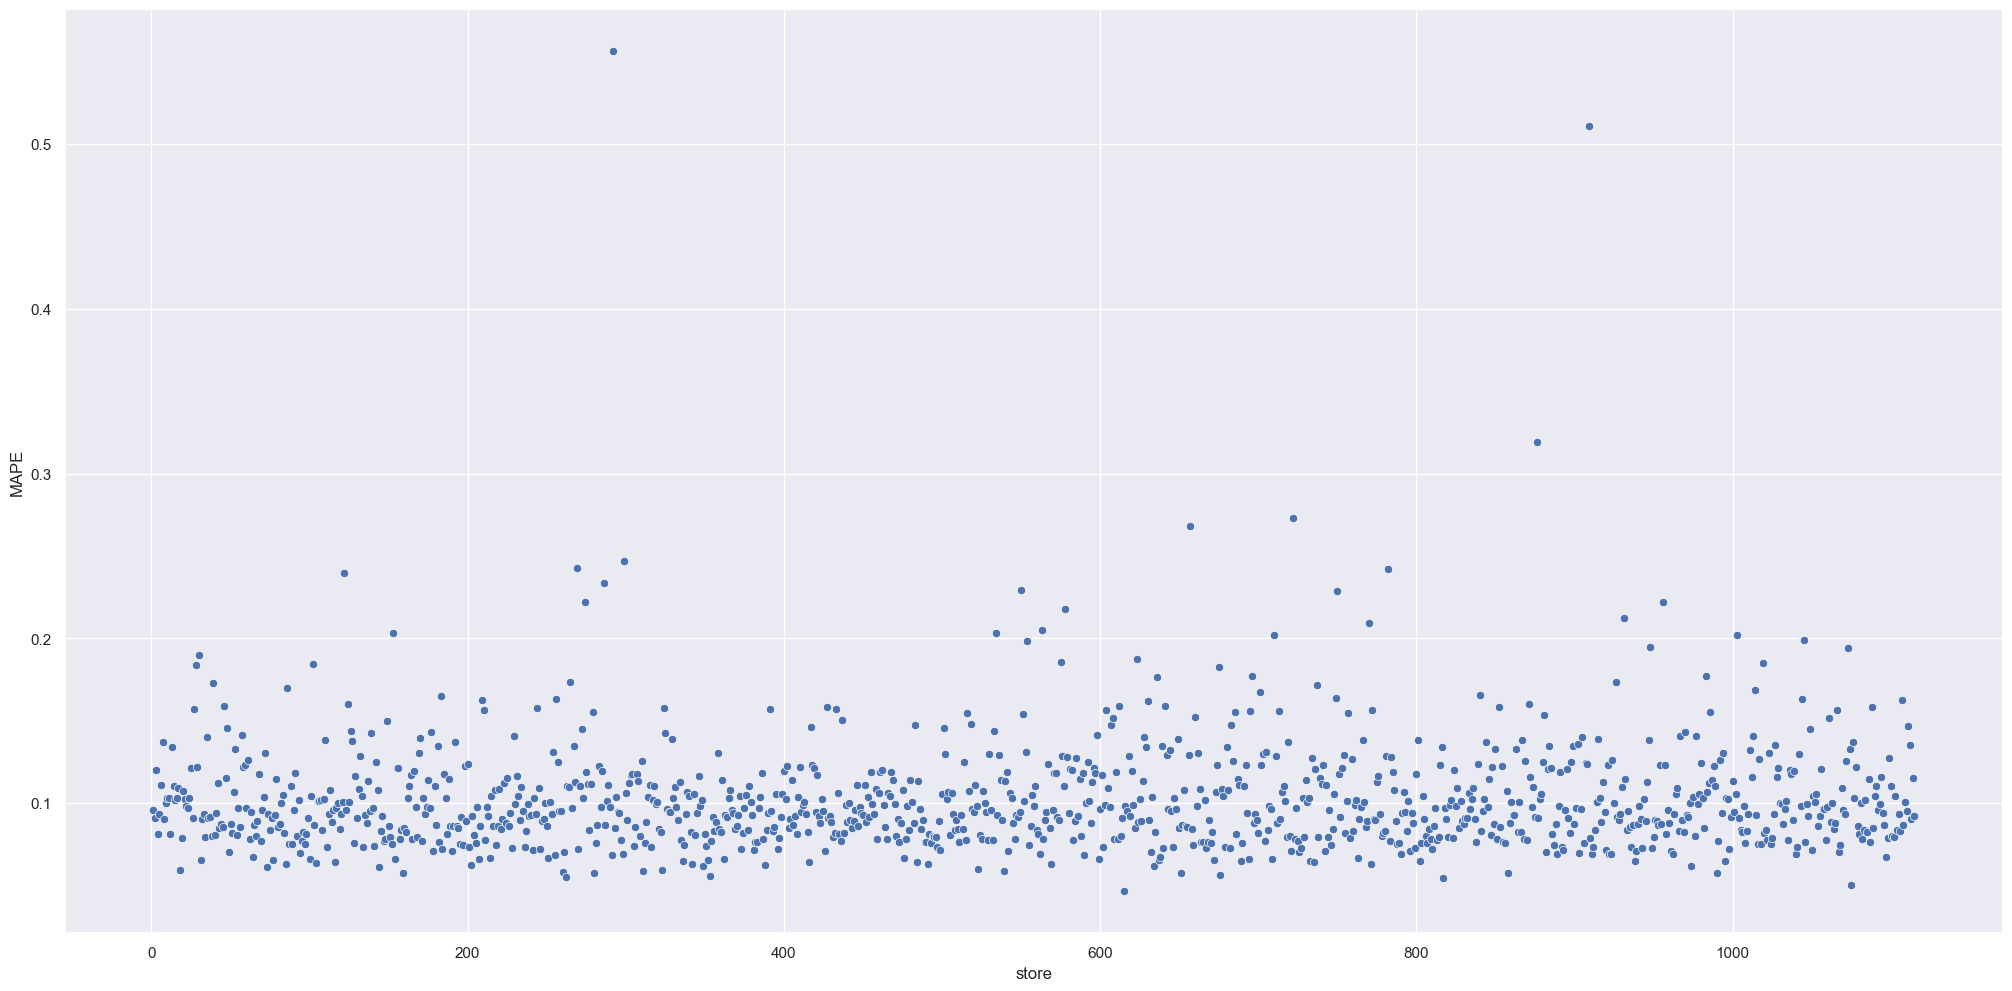

In [94]:
sns.scatterplot( x='store', y='MAPE', data=df92 );

- Algumas lojas tem um resíduo maior do que outras, porém são poucas que passam de 0.4 de MAPE

## 9.2. Total Performance

In [95]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$287,625,152.00"
1,worst_scenario,"R$286,844,020.99"
2,best_scenario,"R$288,406,241.70"


## 9.3. Machine Learning Performance

In [96]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [97]:
df9.head()

,store_te,promo,assortment,competition_distance,competition_open_since_month,competition_time_month,promo_time_week,day_of_week_cos,day_of_week_sin,store,date,sales,predictions,error,error_rate
0,"4,806.46",1,1,-0.17,9,0.93,0.29,-0.22,-0.97,1,2015-07-31,5263,"5,014.39",248.61,0.95
1,"4,980.79",1,1,-0.28,11,1.07,0.94,-0.22,-0.97,2,2015-07-31,6064,"5,160.23",903.77,0.85
2,"6,946.29",1,1,1.90,12,1.22,0.81,-0.22,-0.97,3,2015-07-31,8314,"7,880.07",433.93,0.95
3,"9,586.09",1,3,-0.28,9,0.75,0.29,-0.22,-0.97,4,2015-07-31,13995,"10,254.42","3,740.58",0.73
4,"4,714.70",1,1,4.45,4,-0.16,0.29,-0.22,-0.97,5,2015-07-31,4822,"5,316.59",-494.59,1.10


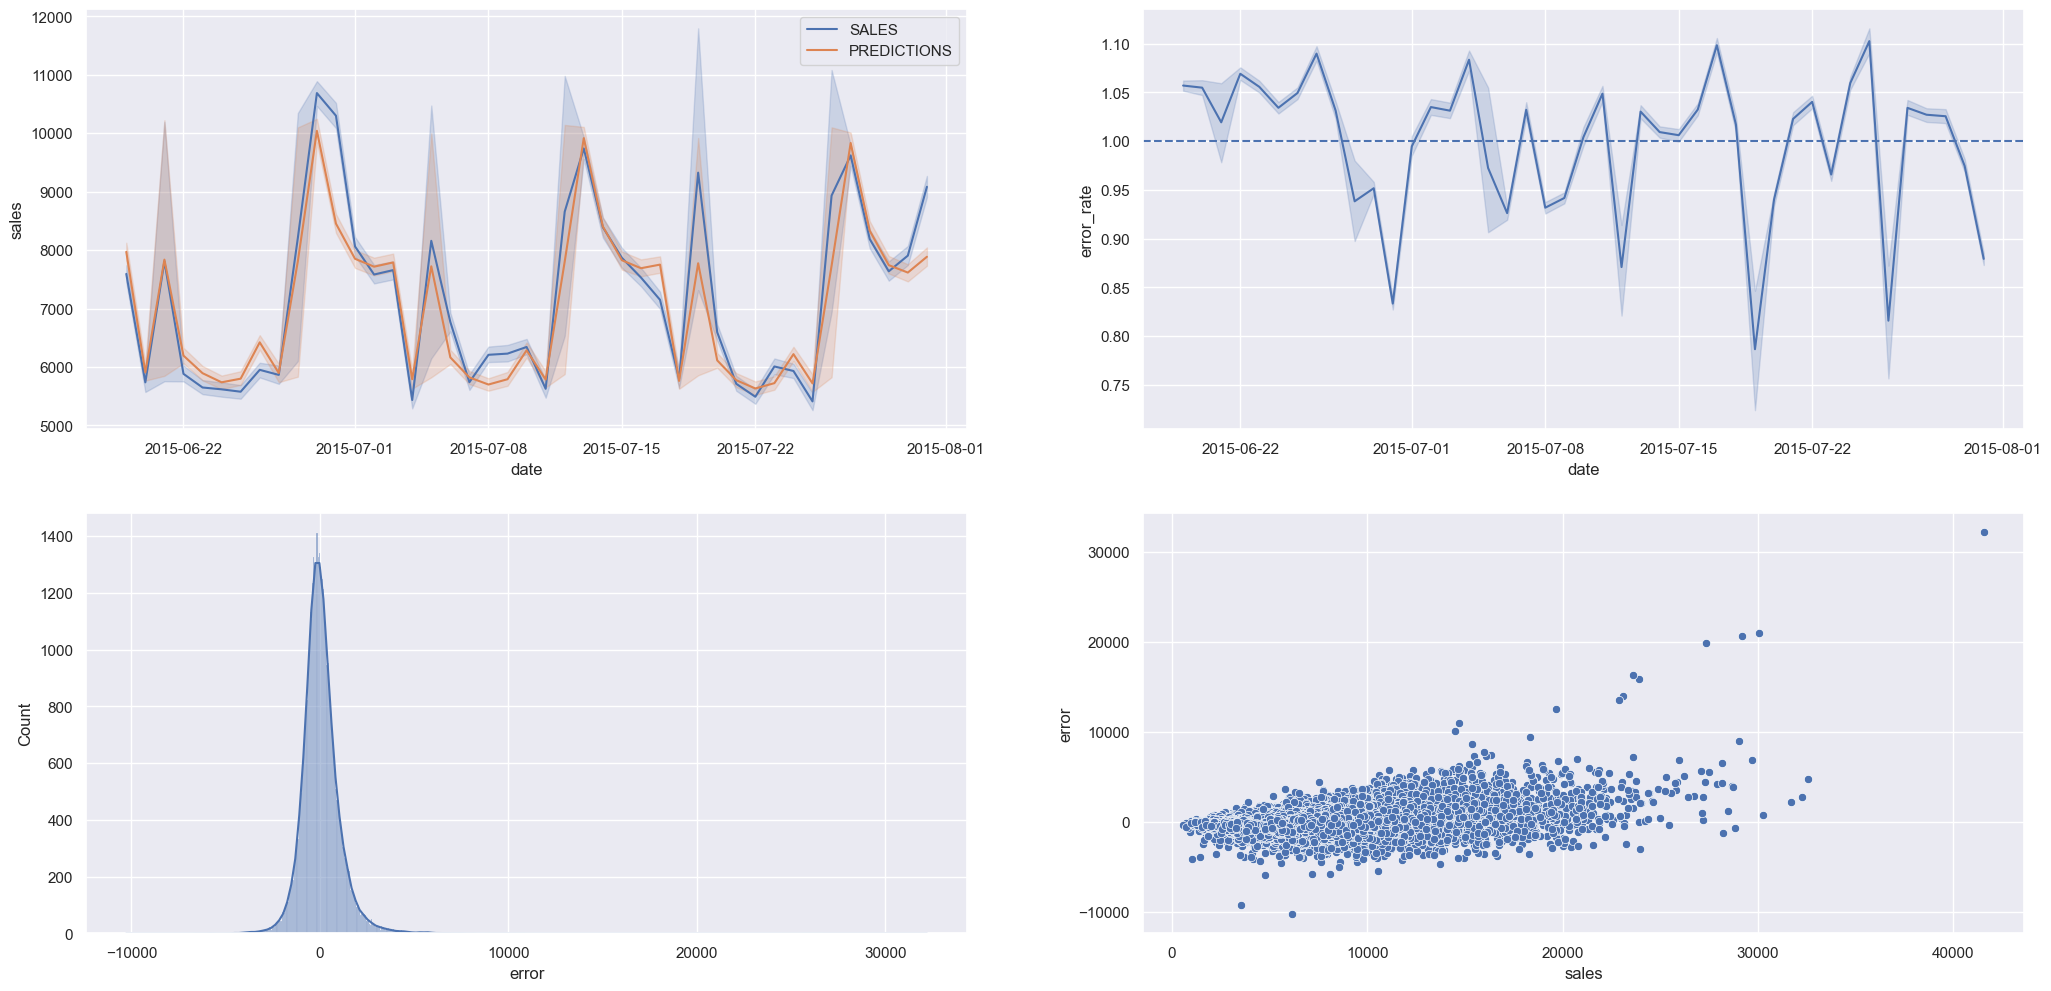

In [99]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.histplot( df9['error'], kde=True )

plt.subplot( 2, 2, 4 )
sns.scatterplot( x=df9['sales'], y=df9['error'] );

- As previsões geralmente subestimam as vendas, como podemos ver nos dois gráfico superiores
- Os resíduos estão normalmente distribuidos e não aumentam nem diminuem conforme as previsões aumentam

## 9.4

In [88]:
competition_distance_scaler   = pickle.load( open('../parameter/competition_distance_scaler.pkl', 'rb') )
competition_time_month_scaler = pickle.load( open('../parameter/competition_time_month_scaler.pkl', 'rb') )
promo_time_week_scaler        = pickle.load( open('../parameter/promo_time_week_scaler.pkl', 'rb') )
year_scaler                   = pickle.load( open('../parameter/year_scaler.pkl', 'rb') )
store_type_scaler             = pickle.load( open('../parameter/store_type_encoder.pkl', 'rb') )
store_te_mapping              = pickle.load( open('../parameter/store_te_mapping.pkl', 'rb'))
store_te_global_mean          = pickle.load( open('../parameter/store_te_global_mean.pkl', 'rb'))


def data_cleaning( df1 ):
        
    ## 1.1. Rename Columns
    cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                        'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
            
    snakecase = lambda x: inflection.underscore( x )
    cols_new = list( map( snakecase, cols_old ) )
    # rename
    df1.columns = cols_new

    ## 1.3. Data Types
    df1['date'] = pd.to_datetime( df1['date'] )
            
    ## 1.5. Fillout NA
    #competition_distance
    df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

    #competition_open_since_month
    df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month 
    if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

    #competition_open_since_year
    df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year 
    if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

    #promo2_since_week
    df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week 
    if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

    #promo2_since_year
    df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year 
    if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

    #promo_interval
    month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    df1['promo_interval'].fillna(0, inplace=True )
    df1['month_map'] = df1['date'].dt.month.map( month_map )
    df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 
    if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

    ## 1.6. Change Data Types
    df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(  np.int64  )
    df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(  np.int64  )

    df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
    df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
    df1['is_promo'] = df1['is_promo'].astype( np.int64 )

            
    return df1

def feature_engineering( df2 ):
        
    # year
    df2['year'] = df2['date'].dt.year
        
    # month
    df2['month'] = df2['date'].dt.month
        
    # day
    df2['day'] = df2['date'].dt.day
        
    # week of year
    df2['week_of_year'] = df2['date'].dt.isocalendar().week 
        
    # year week
    df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
        
    # competition since
    df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )

    df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )
        
    # promo since
    df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
    df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
    df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )
        
    # assortment
    df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
        
    # state holiday
    df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )
        
    # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
    ## 3.1. Filtragem das Linhas
    df2 = df2[df2['open'] != 0]
        
    ## 3.2. Selecao das Colunas
    cols_drop = ['open', 'promo_interval', 'month_map']
    df2 = df2.drop( cols_drop, axis=1 )
        
    return df2


def data_preparation( df5):

    # Target encoding da loja
    df5['store_te'] = df5['store'].map(store_te_mapping).fillna(store_te_global_mean)
        
    # Rescaling apenas do que foi usado
    df5['competition_distance'] = competition_distance_scaler.transform(df5[['competition_distance']].values)
    df5['competition_time_month'] = competition_time_month_scaler.transform(df5[['competition_time_month']].values)
    df5['promo_time_week'] = promo_time_week_scaler.transform(df5[['promo_time_week']].values)

    # Ordinal encoding do assortment
    assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
    df5['assortment'] = df5['assortment'].map(assortment_dict)

    # Transformações sazonais
    df5['day_of_week_sin'] = np.sin(df5['day_of_week'] * (2 * np.pi / 7))
    df5['day_of_week_cos'] = np.cos(df5['day_of_week'] * (2 * np.pi / 7))

    # Seleção final
    cols_selected = [
            'store_te',
            'promo',
            'assortment',
            'competition_distance',
            'competition_open_since_month',
            'competition_time_month',
            'promo_time_week',
            'day_of_week_cos',
            'day_of_week_sin'
        ]

    return df5[cols_selected]

def get_prediction(model, original_data, test_data):
    # prediction
    pred = model.predict(test_data)
    
    # join pred into the original data
    original_data['prediction'] = np.expm1(pred)
    
    # retornar o dataframe com as previsões
    return original_data

In [112]:
df10 = pd.read_csv( '../data/test.csv', index_col=0 ) 
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

In [113]:
# data cleaning
df1 = data_cleaning( df_test )
        
# feature engineering
df2 = feature_engineering( df1 )
        
# data preparation
df3 = data_preparation( df2 )

# prediction
df_response = get_prediction( model_xgb_tuned, df2, df3 )

In [115]:
df_response = df_response[['store', 'store_type', 'assortment', 'date', 'prediction']]
# Assortment
df_response['assortment'] = df_response['assortment'].apply( lambda x: 'basic' if x == 1 else 'extra' if x == 2 else 'extended' )

In [51]:
df_real = df5[['store', 'store_type', 'assortment', 'date', 'sales']]

df_pred = X_test[['store', 'date']].copy()
df_pred['predictions'] = np.expm1( yhat_xgb_tuned )

data = df_real.merge(df_pred, on=['store', 'date'], how='left')
data['is_forecast'] = data['predictions'].notnull()
data['error'] = data['predictions'] - data['sales']
data['error_rate'] = data['error'] / data['sales']

In [54]:
# Split temporal (treino/teste)
cutoff = '2015-06-19'
df_real = data[data['date'] < cutoff].copy()
df_residuals  = data[data['date'] >= cutoff].copy()

In [117]:
df_residuals.to_csv('../data/processed/residuals.csv')
df_real.to_csv('../data/processed/real.csv')
df_response.to_csv('../data/processed/response.csv')

# 10.0. DEPLOY MODEL TO PRODUCTION

In [100]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( '../model/model_rossmann.pkl', 'wb' ) )

## 10.1. Rossman Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    
    def __init__( self ):
        self.home_path= 'C:/Users/Pedro/repos/sales_prediction_rossmann_store/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        self.store_te_mapping              = pickle.load( open( self.home_path + 'parameter/store_te_mapping.pkl', 'rb'))
        self.store_te_global_mean          = pickle.load( open( self.home_path + 'parameter/store_te_global_mean.pkl', 'rb'))

         

    def data_cleaning( self, df1 ):
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )
        
        ## 1.5. Fillout NA
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month 
        if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year 
        if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week 
        if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year 
        if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True )
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 
        if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(  np.int64  )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(  np.int64  )

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        df1['is_promo'] = df1['is_promo'].astype( np.int64 )

        
        return df1
    
    
    def feature_engineering( self, df2 ):
        
        # year
        df2['year'] = df2['date'].dt.year
        
        # month
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day
        
        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week 
        
        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
        
        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )

        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )
        
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )
        
        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
        
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )
        
        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]
        
        ## 3.2. Selecao das Colunas
        cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2
    
    
    def data_preparation(self, df5):

        # Target encoding da loja
        df5['store_te'] = df5['store'].map(self.store_te_mapping).fillna(self.store_te_global_mean)
        
        # Rescaling apenas do que foi usado
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)

        # Ordinal encoding do assortment
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        # Transformações sazonais
        df5['day_of_week_sin'] = np.sin(df5['day_of_week'] * (2 * np.pi / 7))
        df5['day_of_week_cos'] = np.cos(df5['day_of_week'] * (2 * np.pi / 7))

        # Seleção final
        cols_selected = [
            'store_te',
            'promo',
            'assortment',
            'competition_distance',
            'competition_open_since_month',
            'competition_time_month',
            'promo_time_week',
            'day_of_week_cos',
            'day_of_week_sin'
        ]

        return df5[cols_selected]
    
    
    def get_prediction( self, model, original_data, test_data ):
        
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler Class

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( 'C:/Users/Pedro/repos/sales_prediction_rossmann_store/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )

def rossmann_predict():
    
    test_json = request.get_json()
    
    if test_json: # there is data
        
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
    
if __name__ == '__main__':
    app.run( '0.0.0.0')

 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


AttributeError: 'tuple' object has no attribute 'tb_frame'

## 10.3. API Tester

In [25]:
import requests
import json

In [32]:
# loading test dataset
df10 = pd.read_csv( '../data/test.csv' ) 

In [33]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 21, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [34]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [35]:
# API Call
#url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-app-y09g.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [36]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [37]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
    d2.loc[i, 'store'],
    d2.loc[i, 'prediction'] ) )

Store Number 20 will sell R$317,921.65 in the next 6 weeks
Store Number 21 will sell R$235,855.27 in the next 6 weeks
Store Number 22 will sell R$171,976.97 in the next 6 weeks


In [19]:
d1.to_csv('data/predictions.csv')
d1.to_csv('data/predictions_grouped.csv')

OSError: Cannot save file into a non-existent directory: 'data'